In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy.stats import levene, spearmanr

from utils.functions.func_plot_graphs import plot_graphs
from utils.functions.func_fix_date_format import fix_dates 
from utils.functions.func_fix_column_names import snake_case
from utils.functions.func_helper_print_colors import color_print
from utils.functions.func_helper_query_dataset import query_dataframe
from utils.functions.func_helper_duplicate_rows import print_duplicate_rows
from utils.functions.func_helper_convert_date_format import convert_date_format

In [2]:
# Loading dataset config CSV
base_path = os.getcwd()
config_path = os.path.join(base_path, "utils", "configs", "datasets_config.csv")
datasets_df = pd.read_csv(config_path)

# Convert CSV config into dictionary with full paths
dataset_paths = {
    row['name']: os.path.normpath(os.path.join(base_path, row['path']))
    for _, row in datasets_df.iterrows()
}

solarData_path = dataset_paths.get('solarData')
solarData = pd.read_csv(solarData_path, encoding='ISO-8859-1')

In [3]:
query_dataframe(solarData, filepath=solarData_path, encoding='ISO-8859-1')

       Encoding check:
                                                
        Filepath: C:\Users\georgi.petrov\DataScience\00.ExamProject\data\Teague_Table.csv
        Encoding: ISO-8859-1
        Total lines in file (including header): 6902
        Rows loaded in DataFrame: 3450
                                                
                                                

   Dataset Summary:
   DataFrame dimensions: (3450, 8)
                                                
                                                
                                                

   Missing values per column:
                                                
Date                                                              89
No.                                                              473
N / S                                                            473
C / Rn                                                          2031
C / Rs                                                      

In [4]:
solarData['Date']

0        9 Nov 1853
1       17 Nov 1853
2       17 Nov 1853
3       21 Nov 1853
4       23 Nov 1853
           ...     
3445    24 Mar 1861
3446    24 Mar 1861
3447    24 Mar 1861
3448    24 Mar 1861
3449            NaN
Name: Date, Length: 3450, dtype: object

# Датите са във формат който няма да ни е много удобен, най-вероятно
# ще използваме къстъм функция 'fix_dates' с която ще ги обърнем в '%Y-%m-%d'
# като първо за всеки случай ще си копираме стария формат в нова колона -> за целта 'Date_original'

In [5]:
solarData['Date_original'] = solarData['Date']

In [6]:
solarData['Date_original']

0        9 Nov 1853
1       17 Nov 1853
2       17 Nov 1853
3       21 Nov 1853
4       23 Nov 1853
           ...     
3445    24 Mar 1861
3446    24 Mar 1861
3447    24 Mar 1861
3448    24 Mar 1861
3449            NaN
Name: Date_original, Length: 3450, dtype: object

In [7]:
solarData = fix_dates(solarData, 'Date')

# Другото нещо което избожда очи са имената на колоните.

In [8]:
solarData.columns

Index(['Date', 'No.', 'N / S', 'C / Rn', 'C / Rs', 'C / R', 'Wolf',
       '                                                       Notes',
       'Date_original', 'invalid_date'],
      dtype='object')

# ще ги направим питонически -> snake_case
# викаме 'snake_case'
# отново за всеки случай първо ще копираме старите им имена, не, че нямаме дейтасета на няколко места по диска :)
# но да бъдем последователни и систематични

In [9]:
solarData_original_column_names = solarData.columns.copy()

In [10]:
solarData_original_column_names

Index(['Date', 'No.', 'N / S', 'C / Rn', 'C / Rs', 'C / R', 'Wolf',
       '                                                       Notes',
       'Date_original', 'invalid_date'],
      dtype='object')

In [11]:
solarData.columns = solarData.columns.map(snake_case)

In [12]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date'],
      dtype='object')

In [13]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date'],
      dtype='object')

In [14]:
solarData.dtypes

date              object
no                object
n_s               object
c_rn              object
c_rs              object
c_r               object
wolf             float64
notes             object
date_original     object
invalid_date        bool
dtype: object

In [15]:
cols = list(solarData.columns)
for i in range(0, len(cols), 5):
    print(cols[i:i+5])

['date', 'no', 'n_s', 'c_rn', 'c_rs']
['c_r', 'wolf', 'notes', 'date_original', 'invalid_date']


In [16]:
solarData.head()

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date
0,1853-11-09,1,N,11,NaN,11,22.0,NaN,9 Nov 1853,False
1,1853-11-17,1,N,11,NaN,NaN,NaN,NaN,17 Nov 1853,False
2,1853-11-17,2,N,11,NaN,22,28.0,NaN,17 Nov 1853,False
3,1853-11-21,2,N,14,NaN,14,20.0,NaN,21 Nov 1853,False
4,1853-11-23,3,S,NaN,12,12,38.0,NaN,23 Nov 1853,False


# колоната 'n_s' изглежда да показва за кое полукълбо са данните северно или южно
# за момента е оbject, можем да я направим категорийна

In [17]:
solarData['n_s'] = solarData['n_s'].astype('category')

In [18]:
solarData.dtypes

date               object
no                 object
n_s              category
c_rn               object
c_rs               object
c_r                object
wolf              float64
notes              object
date_original      object
invalid_date         bool
dtype: object

In [19]:
solarData.head()

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date
0,1853-11-09,1,N,11,NaN,11,22.0,NaN,9 Nov 1853,False
1,1853-11-17,1,N,11,NaN,NaN,NaN,NaN,17 Nov 1853,False
2,1853-11-17,2,N,11,NaN,22,28.0,NaN,17 Nov 1853,False
3,1853-11-21,2,N,14,NaN,14,20.0,NaN,21 Nov 1853,False
4,1853-11-23,3,S,NaN,12,12,38.0,NaN,23 Nov 1853,False


# ще трябва да се справим с всички NaN's които имаме 
# ако дропнем редовете с NaN's това значи, че ще изтрием и други стойности.
# за този вид данни (слънчева активност) може би NaN значи, че просто няма записана стойност
# в този случай може ни заместванет на NaN с 0 е добър избор, по този начин ще запазим 'notes' и други описателни колони и данни

# тук ще направи провверка преди замяната на NaN's след като сме ги заменили.. mind bending time circle ....

In [20]:
solarData['date'] = pd.to_datetime(solarData['date'], errors='coerce')

# Now check again
print("Earliest date:", solarData['date'].min())
print("Latest date:", solarData['date'].max())
print("Available years sample:", solarData['date'].dt.year.dropna().unique()[:20])

Earliest date: 1853-11-09 00:00:00
Latest date: 1861-03-24 00:00:00
Available years sample: [1853. 1854. 1855. 1856. 1857. 1858. 1859. 1860. 1861.]


In [21]:
numeric_columns = [
    'no',
    'c_rn',
    'c_rs',
    'c_r',
    'wolf'
]

solarData[numeric_columns] = solarData[numeric_columns].fillna(0)
    

In [22]:

nan_counts_before = solarData[numeric_columns].isna().sum()
zero_counts_before = (solarData[numeric_columns] == 0).sum()

print("NaNs before replacement:\n", nan_counts_before)
print("Zeros before replacement:\n", zero_counts_before)

NaNs before replacement:
 no      0
c_rn    0
c_rs    0
c_r     0
wolf    0
dtype: int64
Zeros before replacement:
 no       473
c_rn    2031
c_rs    1816
c_r     2211
wolf    2590
dtype: int64


In [23]:
numeric_columns = [
    'no',
    'c_rn',
    'c_rs',
    'c_r',
    'wolf'
]

solarData[numeric_columns] = solarData[numeric_columns].fillna(0)

# проверяваме дали има някакви NaN  останали в колоните от листа 'numeric_columns' 

In [24]:
check_NaNs = solarData[numeric_columns].isna().sum()
print(check_NaNs)

no      0
c_rn    0
c_rs    0
c_r     0
wolf    0
dtype: int64


# можем да проверим дали взичките замествания са ссега нули

In [25]:
zero_check = (solarData[numeric_columns] == 0).sum()
print(zero_check)

no       473
c_rn    2031
c_rs    1816
c_r     2211
wolf    2590
dtype: int64


# имаме предварителна проверка за липсващи стойности, викайни  функцията 'query_dataframe(solarData, filepath=solarData_path, encoding='ISO-8859-1')'
# където имаме резултат 
Missing values per column:
                                                
Date               89
No.                473
N / S              473
C / Rn             2031
C / Rs             1816
C / R              2211
Wolf               2211
Notes              2854


# виждаме, че повечето ни стойности (от заместените) съвпадат с изкючение на 'wolf' която след заместването има малко повече 0,
# това може да означава, че преди това също е имало 0 като стойности.
# можем да проверим като се върнем преди да заместим NaN's с 0 и да направим няколко проверки

# от клетка 26 виждаме, че преди да заменим NaN's с 0 в колоната 'wolf' е имало 
'wolf    379'
# толкова 0 освевн NaN's.. 2211+379 = 2590
# значи сметката ни излиза и цифрите които получаваме след като заместихме NaN's с 0 са верни

In [26]:
print(solarData.dtypes)

date             datetime64[ns]
no                       object
n_s                    category
c_rn                     object
c_rs                     object
c_r                      object
wolf                    float64
notes                    object
date_original            object
invalid_date               bool
dtype: object


In [27]:
print(solarData.isnull().sum())

date               99
no                  0
n_s               473
c_rn                0
c_rs                0
c_r                 0
wolf                0
notes            2854
date_original      89
invalid_date        0
dtype: int64


In [28]:
print(solarData.describe(include='all'))

                                 date      no   n_s    c_rn    c_rs     c_r  \
count                            3351  3450.0  2977  3450.0  3450.0  3450.0   
unique                            NaN   948.0     2    41.0    51.0   152.0   
top                               NaN     0.0     S     0.0     0.0     0.0   
freq                              NaN   473.0  1596  2031.0  1816.0  2211.0   
mean    1858-09-21 18:56:36.956131840     NaN   NaN     NaN     NaN     NaN   
min               1853-11-09 00:00:00     NaN   NaN     NaN     NaN     NaN   
25%               1857-06-02 00:00:00     NaN   NaN     NaN     NaN     NaN   
50%               1859-05-08 00:00:00     NaN   NaN     NaN     NaN     NaN   
75%               1860-06-25 00:00:00     NaN   NaN     NaN     NaN     NaN   
max               1861-03-24 00:00:00     NaN   NaN     NaN     NaN     NaN   
std                               NaN     NaN   NaN     NaN     NaN     NaN   

               wolf              notes date_origina

In [29]:
solarData.head()

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date
0,1853-11-09,1,N,11,0,11,22.0,NaN,9 Nov 1853,False
1,1853-11-17,1,N,11,0,0,0.0,NaN,17 Nov 1853,False
2,1853-11-17,2,N,11,0,22,28.0,NaN,17 Nov 1853,False
3,1853-11-21,2,N,14,0,14,20.0,NaN,21 Nov 1853,False
4,1853-11-23,3,S,0,12,12,38.0,NaN,23 Nov 1853,False


In [30]:
print(solarData.dtypes)

date             datetime64[ns]
no                       object
n_s                    category
c_rn                     object
c_rs                     object
c_r                      object
wolf                    float64
notes                    object
date_original            object
invalid_date               bool
dtype: object


# вижда се, че имаме колони съдържащи числа, но са от тип 'object', което си пролича и при '.describe()'
# която не преизчисли някои от редовете правилно защото колоните са от тип 'object'
# дори и да имаме 0 в колона, ако тя е тип 'object', .decribe() я третира като категорийна и показва NaN

# ще сменим типа на тези колони на нумерик

In [31]:
numeric_int_cols = ['no', 'c_rn', 'c_rs', 'c_r']
for col in numeric_int_cols:
    solarData[col] = pd.to_numeric(solarData[col], errors='coerce').astype('Int64')

In [32]:
print(solarData.dtypes)

date             datetime64[ns]
no                        Int64
n_s                    category
c_rn                      Int64
c_rs                      Int64
c_r                       Int64
wolf                    float64
notes                    object
date_original            object
invalid_date               bool
dtype: object


# сега вече поне привидно колоните изглеждат добре и са готови за някакви агрегации

# и сега ако пробваме пак .describeO, на теория би трябввало тези колони да са преизчислени коректно

In [33]:
print(solarData.describe(include='all'))

                                 date          no   n_s      c_rn      c_rs  \
count                            3351      3393.0  2977    3441.0    3447.0   
unique                            NaN        <NA>     2      <NA>      <NA>   
top                               NaN        <NA>     S      <NA>      <NA>   
freq                              NaN        <NA>  1596      <NA>      <NA>   
mean    1858-09-21 18:56:36.956131840  431.480106   NaN  6.176983  7.291268   
min               1853-11-09 00:00:00         0.0   NaN       0.0       0.0   
25%               1857-06-02 00:00:00       130.0   NaN       0.0       0.0   
50%               1859-05-08 00:00:00       414.0   NaN       0.0       0.0   
75%               1860-06-25 00:00:00       745.0   NaN      12.0      12.0   
max               1861-03-24 00:00:00       954.0   NaN      59.0      67.0   
std                               NaN  322.855426   NaN  8.561053  9.345027   

              c_r         wolf              notes d

# виждаме, че 'numeric' колоните вече се преизчисляват както трябва

In [34]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date'],
      dtype='object')

In [35]:
solarData.dtypes

date             datetime64[ns]
no                        Int64
n_s                    category
c_rn                      Int64
c_rs                      Int64
c_r                       Int64
wolf                    float64
notes                    object
date_original            object
invalid_date               bool
dtype: object

In [36]:
solarData.head(10)

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date
0,1853-11-09,1,N,11,0,11,22.0,NaN,9 Nov 1853,False
1,1853-11-17,1,N,11,0,0,0.0,NaN,17 Nov 1853,False
2,1853-11-17,2,N,11,0,22,28.0,NaN,17 Nov 1853,False
3,1853-11-21,2,N,14,0,14,20.0,NaN,21 Nov 1853,False
4,1853-11-23,3,S,0,12,12,38.0,NaN,23 Nov 1853,False
5,1853-11-25,3,S,0,11,0,0.0,NaN,25 Nov 1853,False
6,1853-11-25,4,N,11,0,22,36.0,NaN,25 Nov 1853,False
7,NaT,0,NaN,0,0,0,0.0,"Rn = 11.6, Rs = 4.6, R = 16.2.",NaN,True
8,1853-12-01,5,S,0,13,13,14.0,NaN,1 Dec 1853,False
9,1853-12-02,5,S,0,12,0,0.0,NaN,2 Dec 1853,False


In [37]:
solarData['date']

0      1853-11-09
1      1853-11-17
2      1853-11-17
3      1853-11-21
4      1853-11-23
          ...    
3445   1861-03-24
3446   1861-03-24
3447   1861-03-24
3448   1861-03-24
3449          NaT
Name: date, Length: 3450, dtype: datetime64[ns]

solarData_dateColumn_fixed_dates = solarData = fix_dates(solarData, 'date')

solarData_dateColumn_original_dates = solarData.columns.copy()

In [38]:
solarData.head()

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date
0,1853-11-09,1,N,11,0,11,22.0,NaN,9 Nov 1853,False
1,1853-11-17,1,N,11,0,0,0.0,NaN,17 Nov 1853,False
2,1853-11-17,2,N,11,0,22,28.0,NaN,17 Nov 1853,False
3,1853-11-21,2,N,14,0,14,20.0,NaN,21 Nov 1853,False
4,1853-11-23,3,S,0,12,12,38.0,NaN,23 Nov 1853,False


# сега след като сме пооправили колоните и данните, можем да тестваме дали можем да покажем някакви статистики

# като начало можем да си направим една матрица с колоните които ще използваме за статистика 

In [39]:
numerical_columns = ['no', 'c_rn', 'c_rs', 'c_r', 'wolf']

# тук е може би добре да споменем коя колона какво значи
# данните са свалени под формата на csv от https://sidc.be/SILSO/home и съдържат измервания в промяната на наблюдаемите
# слънчеви петна
no    →   номер на наблюдението (последователност на наблюденията за дадена дата).
n_s   →   слънчево полукълбо, N или S (Северно или Южно полукълбо).
c_rn  →   брой слънчеви групи в северното слънчево полукълбо.
c_rs  →   брой слънчеви групи в южното слънчево полукълбо.
c_r   →   общо число на слънчевите групи (вероятно сбор от c_rn и c_rs).
wolf  →   число на Волф за слънчеви петна .
notes →   бележки във свободен текст за всяко наблюдение.
date  →   дата на наблюдението.

In [40]:
correlation_matrix = solarData[numeric_columns].corr()
print(correlation_matrix)

            no      c_rn      c_rs       c_r      wolf
no    1.000000  0.222134  0.158107  0.114561  0.086972
c_rn  0.222134  1.000000 -0.564677  0.076566  0.071182
c_rs  0.158107 -0.564677  1.000000  0.008699 -0.006061
c_r   0.114561  0.076566  0.008699  1.000000  0.963700
wolf  0.086972  0.071182 -0.006061  0.963700  1.000000


# виждаме матрица на корелациите
c_r и wolf → 0.96 корелация
Изключително висока и очаквана — числото на Wolf се изчислява частично на базата на броя на групите слънчеви петна (и отделните петна), така че c_r и wolf се движат почти еднакво.

c_rn и c_rs → -0.56 корелация
Умерено силна отрицателна корелация — когато има повече групи в Северното полукълбо, обикновено има по-малко в Южното, и обратно. Това вероятно се дължи на фазови измествания в активността между полукълбата на Слънцето.

no спрямо другите (0.08–0.22)
Много слаби корелации — no е просто пореден номер на наблюдението за дадена дата, така че няма силна връзка със самите нива на слънчева активност.

Останалите стойности са близо до 0
Това означава, че има малка или никаква линейна зависимост между съответните двойки променливи. 

# да начертаем хийтмап

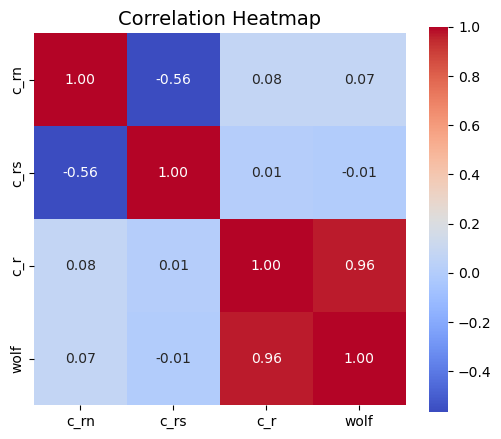

In [41]:
numeric_columns = ['c_rn', 'c_rs', 'c_r', 'wolf']
correlation_matrix = solarData[numeric_columns].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap", fontsize=14)
plt.savefig('correlation_heatmap.jpg', dpi=300) 
plt.show()

# можем да се опитаме да покажем общото разпределение на слънчевите групи

In [42]:
solarData[['c_rn', 'c_rs', 'c_r']].describe()

,c_rn,c_rs,c_r
count,3441.0,3447.0,3449.0
mean,6.176983,7.291268,13.463613
std,8.561053,9.345027,31.598113
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,12.0,12.0,0.0
max,59.0,67.0,192.0


# как можем да изтълкуваме това което виждаме

средна стойност (mean):
c_rn (северно полукълбо): 6.18
c_rs (южно полукълбо): 7.29
c_r  (общо групи): 13.46
→ Средно повече групи се наблюдават в южното полукълбо.

стандартно отклонение (std):
c_r е много голямо (31.6), което може да означава, че има големи вариации между наблюденията – някои дни са с много групи, други с почти нула.

минимум и 25% медиана:
мого наблюдения са 0 (за 25% и за 50% медианата е 0 за c_rn и c_rs).
това може да значи, че има много дни без наблюдавани слънчеви групи.

максимум и 75% квантил:
наблюдават се много високи максимуми (59 и 67), което показва силни слънчеви активности в отделни дни.
интересно е, че за c_r 75% квантил е 0. Това показва, че голяма част от дните имат ниска активност.

# средната активност на слънцето, какву са вариацията между северното и южното полукълбо, максимални и минимални стойности.

# понеже това са просто числа, можем да се опитаме да покажем процентно 
# броя на дните в които няма наблюдавани слънчеви групи

In [43]:
NortSun_zero_groups = (solarData['c_rn'] == 0).sum()
print(NortSun_zero_groups)

2069


In [44]:
SouthSun_zero_groups = (solarData['c_rs'] == 0).sum()
print(SouthSun_zero_groups)

1856


In [45]:
TotalDays_zero_groups = (solarData['c_r'] == 0).sum()
print(TotalDays_zero_groups)

2595


In [46]:
total_days = len(solarData)
percent_north = NortSun_zero_groups / total_days * 100
percent_south = SouthSun_zero_groups / total_days * 100
percent_total = TotalDays_zero_groups / total_days * 100

print(f"Процент дни без групи в северното полукълбо: {percent_north:.2f}%")
print(f"Процент дни без групи в южното полукълбо: {percent_south:.2f}%")
print(f"Процент дни без групи общо: {percent_total:.2f}%")

Процент дни без групи в северното полукълбо: 59.97%
Процент дни без групи в южното полукълбо: 53.80%
Процент дни без групи общо: 75.22%


In [47]:
daily = (solarData.groupby('date')
         .agg(c_rn=('c_rn', lambda s: s.sum(min_count=1)),
              c_rs=('c_rs', lambda s: s.sum(min_count=1)),
              c_r =('c_r',  lambda s: s.sum(min_count=1)))
         .reset_index())

# 2) Hemisphere-specific "zero" rates among days that were actually observed
p_north_zero = daily.loc[daily.c_rn.notna(), 'c_rn'].eq(0).mean() * 100
p_south_zero = daily.loc[daily.c_rs.notna(), 'c_rs'].eq(0).mean() * 100

# 3) Overall "zero groups" (strict: only days with BOTH hemispheres observed)
both_obs = daily.c_rn.notna() & daily.c_rs.notna()
p_zero_groups_strict = ((daily.loc[both_obs, 'c_rn'] + daily.loc[both_obs, 'c_rs']).eq(0)
                        .mean() * 100)

# 4) Overall "zero groups" (lenient: assume missing = 0)  ← may overestimate zeros
p_zero_groups_lenient = ((daily['c_rn'].fillna(0) + daily['c_rs'].fillna(0)).eq(0)
                         .mean() * 100)

# 5) Zero *spots* days (if you want this too; different concept)
p_zero_spots = daily.loc[daily.c_r.notna(), 'c_r'].eq(0).mean() * 100

In [48]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date'],
      dtype='object')

In [49]:
solarData[['c_rn', 'c_rs', 'c_r', 'wolf']].corr()

,c_rn,c_rs,c_r,wolf
c_rn,1.000000,-0.564677,0.076566,0.071182
c_rs,-0.564677,1.000000,0.008699,-0.006061
c_r,0.076566,0.008699,1.000000,0.963700
wolf,0.071182,-0.006061,0.963700,1.000000


In [50]:
solarData['wolf_expected'] = 10 * (solarData['c_rn'].fillna(0) + 
                                   solarData['c_rs'].fillna(0)) + \
                             solarData['c_r'].fillna(0)

solarData['wolf_diff'] = solarData['wolf'] - solarData['wolf_expected']

In [51]:
print(solarData[['date','no','c_rn','c_rs','c_r','wolf','wolf_expected','wolf_diff']].head(20))
print(solarData['wolf_diff'].describe())

         date  no  c_rn  c_rs  c_r  wolf  wolf_expected  wolf_diff
0  1853-11-09   1    11     0   11  22.0            121      -99.0
1  1853-11-17   1    11     0    0   0.0            110     -110.0
2  1853-11-17   2    11     0   22  28.0            132     -104.0
3  1853-11-21   2    14     0   14  20.0            154     -134.0
4  1853-11-23   3     0    12   12  38.0            132      -94.0
5  1853-11-25   3     0    11    0   0.0            110     -110.0
6  1853-11-25   4    11     0   22  36.0            132      -96.0
7         NaT   0     0     0    0   0.0              0        0.0
8  1853-12-01   5     0    13   13  14.0            143     -129.0
9  1853-12-02   5     0    12    0   0.0            120     -120.0
10 1853-12-02   6     0    11   23  12.0            133     -121.0
11 1853-12-08   6     0    15    0   0.0            150     -150.0
12 1853-12-08   7    13     0   28  24.0            158     -134.0
13 1853-12-09   6     0    11    0   0.0            110     -1

In [52]:
solarData['wolf_alt'] = (
    solarData['c_rn'].fillna(0) +
    solarData['c_rs'].fillna(0) +
    solarData['c_r'].fillna(0)
)

solarData['wolf_check'] = solarData['wolf'] - solarData['wolf_alt']
print(solarData['wolf_check'].describe())
print(solarData[['wolf','wolf_alt','wolf_check']].head(20))

count       3450.0
mean    -14.433043
std      12.727569
min         -132.0
25%          -18.0
50%          -12.0
75%          -11.0
max           54.0
Name: wolf_check, dtype: Float64
    wolf  wolf_alt  wolf_check
0   22.0        22         0.0
1    0.0        11       -11.0
2   28.0        33        -5.0
3   20.0        28        -8.0
4   38.0        24        14.0
5    0.0        11       -11.0
6   36.0        33         3.0
7    0.0         0         0.0
8   14.0        26       -12.0
9    0.0        12       -12.0
10  12.0        34       -22.0
11   0.0        15       -15.0
12  24.0        41       -17.0
13   0.0        11       -11.0
14  30.0        39        -9.0
15  22.0        26        -4.0
16   0.0        13       -13.0
17   0.0        11       -11.0
18  34.0        46       -12.0
19   0.0        12       -12.0


In [53]:
solarData['wolf_corrected'] = solarData['wolf']

mask_missing = solarData['wolf_corrected'].isna() | (solarData['wolf_corrected'] == 0)
solarData.loc[mask_missing, 'wolf_corrected'] = solarData.loc[mask_missing, 'wolf_alt']

In [54]:
daily_wolf = (
    solarData.groupby('date')['wolf_corrected']
    .mean()
    .to_frame()
    .rename(columns={'wolf_corrected':'wolf'})
)

In [55]:
date_range = pd.date_range(daily_wolf.index.min(),
                           daily_wolf.index.max(), freq='D')
daily_wolf = daily_wolf.reindex(date_range)
daily_wolf.index.name = 'date'

In [56]:
daily_wolf['wolf_interp'] = daily_wolf['wolf'].interpolate()

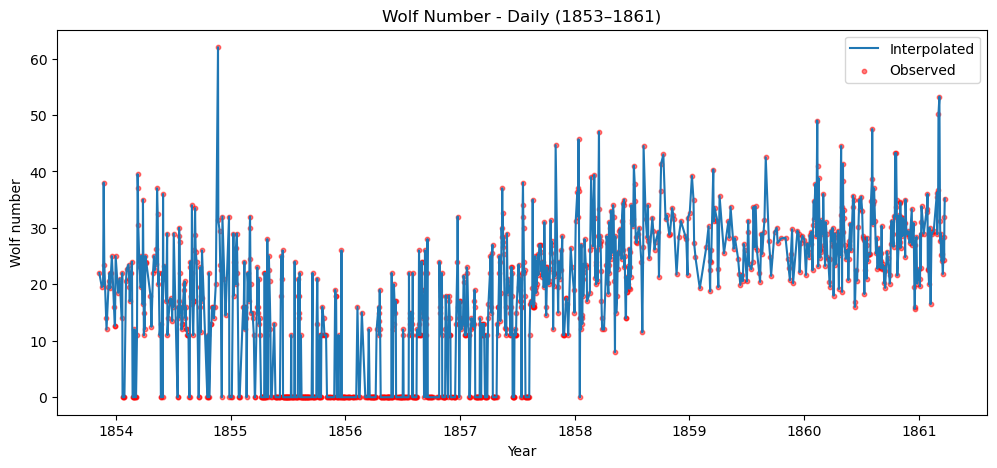

In [57]:
plt.figure(figsize=(12,5))
plt.plot(daily_wolf.index, daily_wolf['wolf_interp'], label='Interpolated')
plt.scatter(daily_wolf.index, daily_wolf['wolf'], s=10, alpha=0.5, label='Observed', c = "r")
plt.title("Wolf Number - Daily (1853–1861)")
plt.ylabel("Wolf number")
plt.xlabel("Year")
plt.legend()
plt.savefig('Wofl_daily.jpg', dpi=300) 
plt.show()

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_24560\2444084105.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_wolf = daily_wolf['wolf_interp'].resample('M').mean()


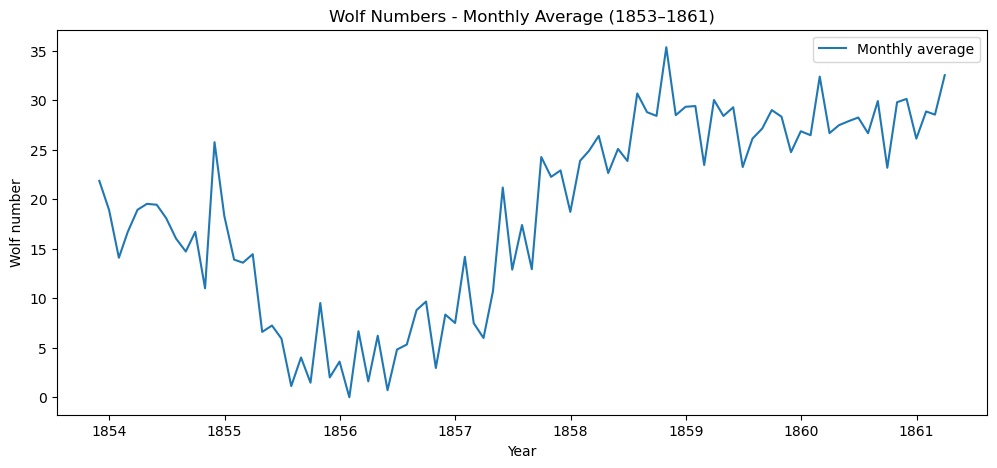

In [58]:
monthly_wolf = daily_wolf['wolf_interp'].resample('M').mean()

import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(monthly_wolf.index, monthly_wolf, label='Monthly average', color='tab:blue')
plt.title("Wolf Numbers - Monthly Average (1853–1861)")
plt.ylabel("Wolf number")
plt.xlabel("Year")
plt.legend()
plt.savefig('Wofl_monthly.jpg', dpi=300) 
plt.show()

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_24560\1110555918.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_wolf = daily_wolf['wolf_interp'].resample('Y').mean()


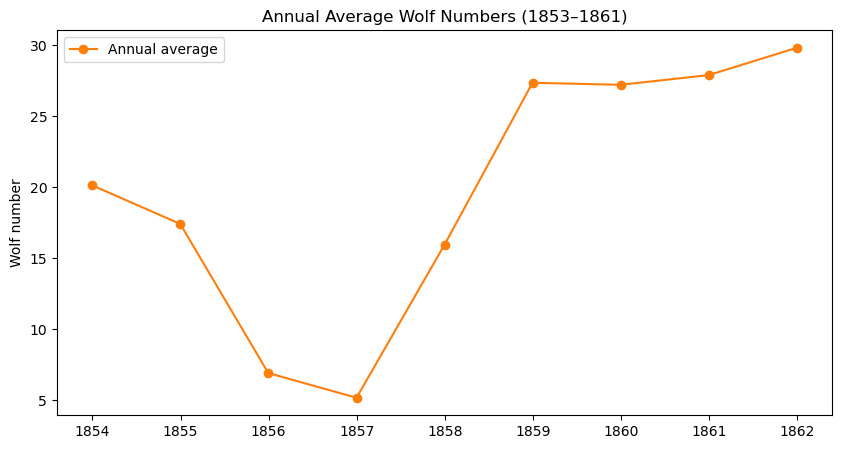

In [59]:
annual_wolf = daily_wolf['wolf_interp'].resample('Y').mean()

plt.figure(figsize=(10,5))
plt.plot(annual_wolf.index, annual_wolf, marker='o', color='tab:orange', label='Annual average')
plt.title("Annual Average Wolf Numbers (1853–1861)")
plt.ylabel("Wolf number")
plt.legend()
plt.savefig('Wofl_daily.jpg', dpi=300) 
plt.show()

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_24560\1711219701.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_wolf = daily_wolf['wolf_interp'].resample('Y').mean()


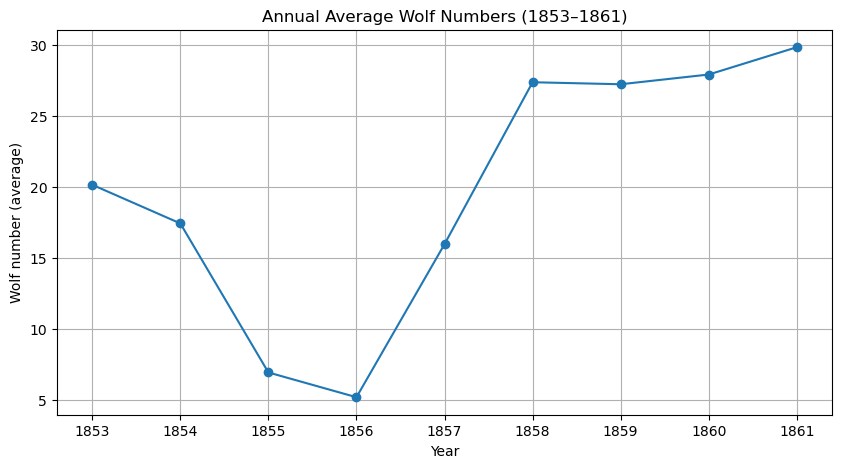

In [60]:
annual_wolf = daily_wolf['wolf_interp'].resample('Y').mean()

plt.figure(figsize=(10,5))
plt.plot(annual_wolf.index.year, annual_wolf.values, marker='o')
plt.title("Annual Average Wolf Numbers (1853–1861)")
plt.xlabel("Year")
plt.ylabel("Wolf number (average)")
plt.grid(True)
plt.show()

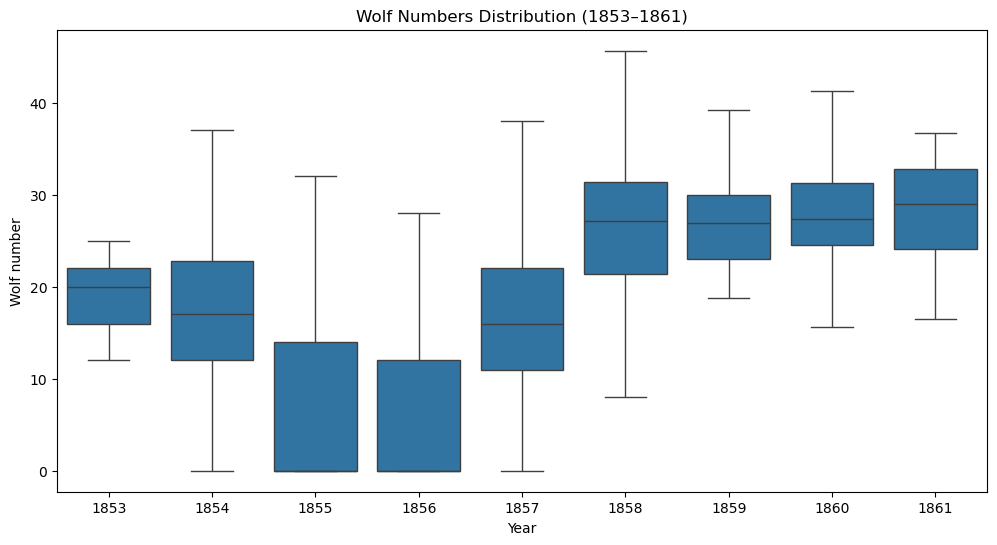

In [61]:
import seaborn as sns

# Prepare dataframe with year extracted
df_yearly = daily_wolf.copy()
df_yearly = df_yearly.reset_index()
df_yearly['year'] = df_yearly['date'].dt.year

plt.figure(figsize=(12,6))
sns.boxplot(x='year', y='wolf', data=df_yearly, showfliers=False)
plt.title("Wolf Numbers Distribution (1853–1861)")
plt.xlabel("Year")
plt.ylabel("Wolf number")
plt.savefig('Wofl_daily_dist.jpg', dpi=300) 
plt.show()

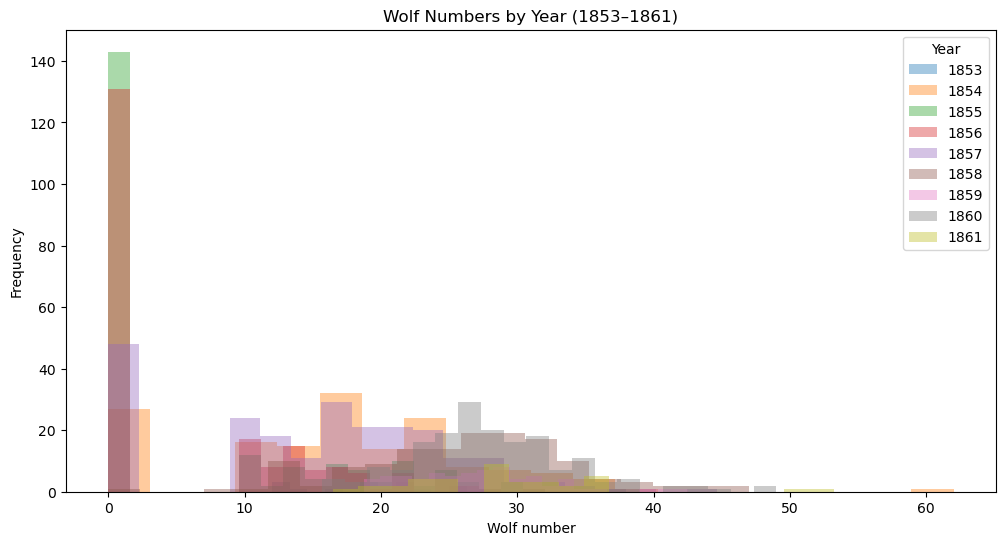

In [62]:
plt.figure(figsize=(12,6))
df_yearly.groupby('year')['wolf'].plot(kind='hist', alpha=0.4, bins=20, legend=True)
plt.title("Wolf Numbers by Year (1853–1861)")
plt.xlabel("Wolf number")
plt.ylabel("Frequency")
plt.legend(title='Year')
plt.savefig('Wofl_histogram.jpg', dpi=300) 
plt.show()

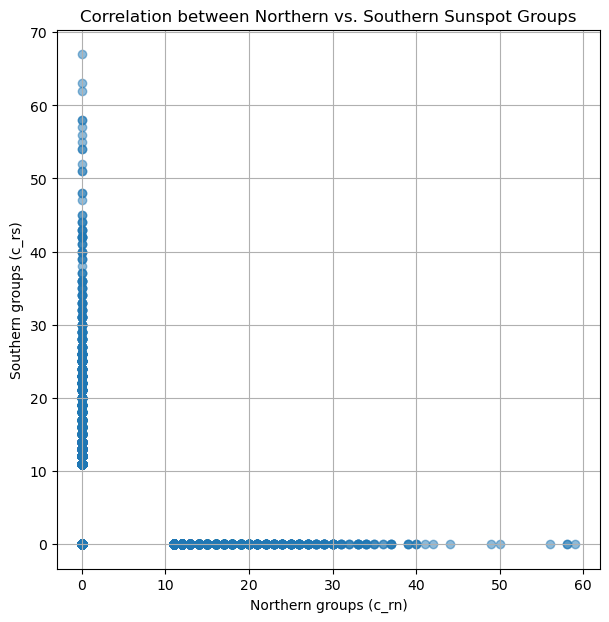

In [63]:
plt.figure(figsize=(7,7))
plt.scatter(solarData['c_rn'], solarData['c_rs'], alpha=0.5)
plt.xlabel("Northern groups (c_rn)")
plt.ylabel("Southern groups (c_rs)")
plt.title("Correlation between Northern vs. Southern Sunspot Groups")
regression=True
plt.grid(True)
plt.show()

In [64]:
print(solarData[['c_rn','c_rs']].corr())

          c_rn      c_rs
c_rn  1.000000 -0.564677
c_rs -0.564677  1.000000


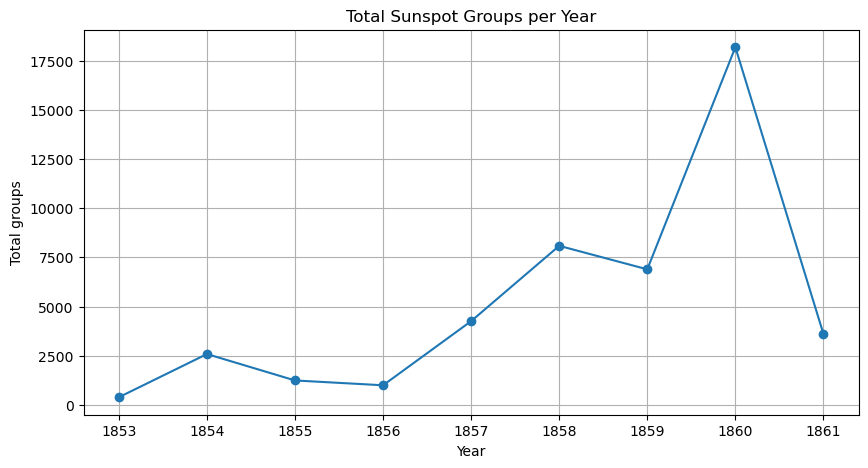

In [65]:
solarData['groups_total'] = solarData['c_rn'].fillna(0) + solarData['c_rs'].fillna(0)

groups_yearly = solarData.groupby(solarData['date'].dt.year)['groups_total'].sum()

plt.figure(figsize=(10,5))
plt.plot(groups_yearly.index, groups_yearly.values, marker='o')
plt.title("Total Sunspot Groups per Year")
plt.xlabel("Year")
plt.ylabel("Total groups")
plt.grid(True)
plt.show()

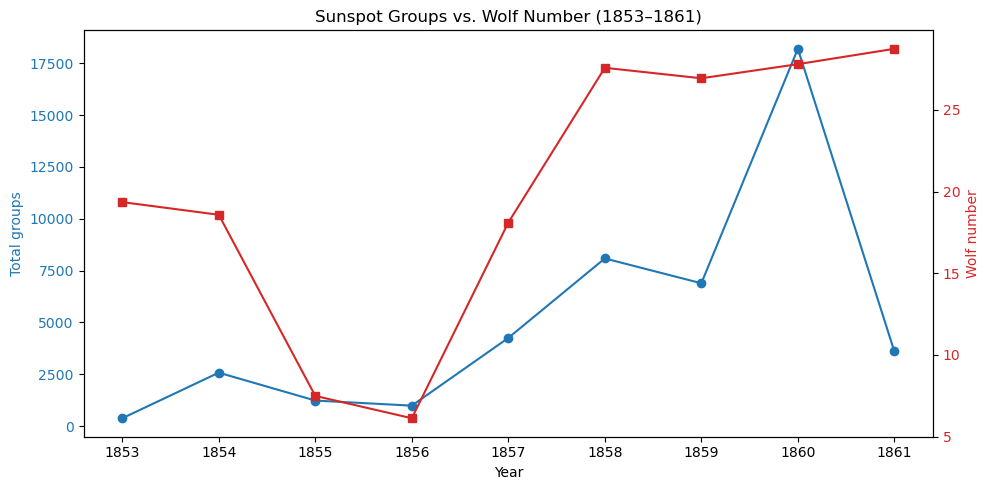

In [66]:
wolf_yearly = solarData.groupby(solarData['date'].dt.year)['wolf_corrected'].mean()

fig, ax1 = plt.subplots(figsize=(10,5))

# Left axis = total groups
ax1.plot(groups_yearly.index, groups_yearly.values, color='tab:blue', marker='o', label='Total groups')
ax1.set_xlabel("Year")
ax1.set_ylabel("Total groups", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right axis = Wolf number
ax2 = ax1.twinx()
ax2.plot(wolf_yearly.index, wolf_yearly.values, color='tab:red', marker='s', label='Wolf number')
ax2.set_ylabel("Wolf number", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Sunspot Groups vs. Wolf Number (1853–1861)")
fig.tight_layout()
plt.savefig('Groups_vs_Wofl.jpg', dpi=300) 
plt.show()

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_24560\1318436096.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


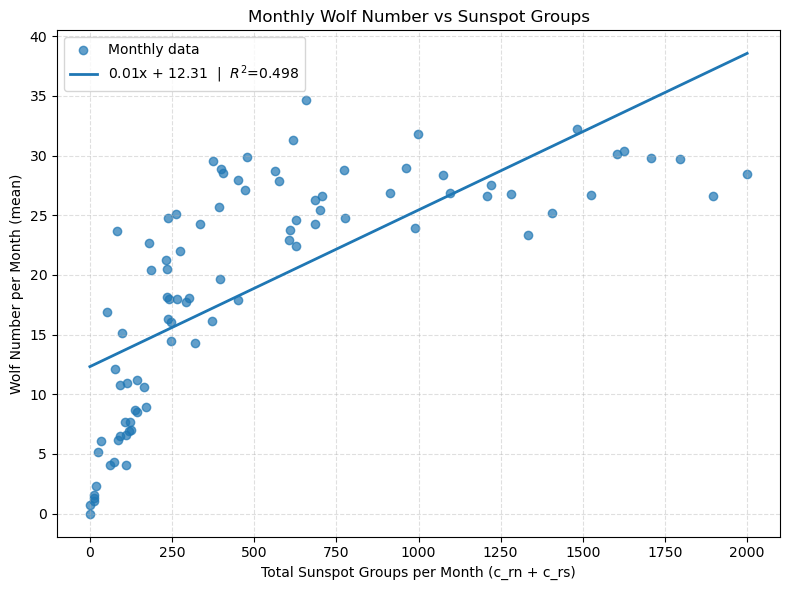

In [67]:
# --- Prep monthly data ---
df = solarData.copy()
df['groups_total'] = df['c_rn'].fillna(0).astype(float) + df['c_rs'].fillna(0).astype(float)

# Use the corrected Wolf column if you created it earlier; else fall back to wolf
wolf_col = 'wolf_corrected' if 'wolf_corrected' in df.columns else 'wolf'

# Monthly aggregates
monthly = (
    df.set_index('date')
      .resample('M')
      .agg({
          'groups_total': 'sum',     # total groups in month
          'c_r': 'sum',              # total spots in month (optional alt X)
          wolf_col: 'mean'           # average Wolf in month
      })
      .dropna(subset=[wolf_col])     # keep months with Wolf data
)

# --- Choose X for the scatter ---
# Option A (recommended): total groups per month
x = monthly['groups_total'].values
x_label = 'Total Sunspot Groups per Month (c_rn + c_rs)'

# If you prefer total *spots* (as in your figure label with c_r), swap:
# x = monthly['c_r'].values
# x_label = 'Total Sunspots per Month (c_r)'

y = monthly[wolf_col].values

# --- Fit simple linear regression y = a*x + b ---
a, b = np.polyfit(x, y, 1)
y_hat = a*x + b

# R^2
ss_res = np.sum((y - y_hat)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - ss_res/ss_tot

# --- Plot ---
plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.7, label='Monthly data')
plt.plot(np.sort(x), (a*np.sort(x) + b), linewidth=2, label=f'{a:.2f}x + {b:.2f}  |  $R^2$={r2:.3f}')
plt.title('Monthly Wolf Number vs Sunspot Groups')
plt.xlabel(x_label)
plt.ylabel('Wolf Number per Month (mean)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_24560\346937435.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


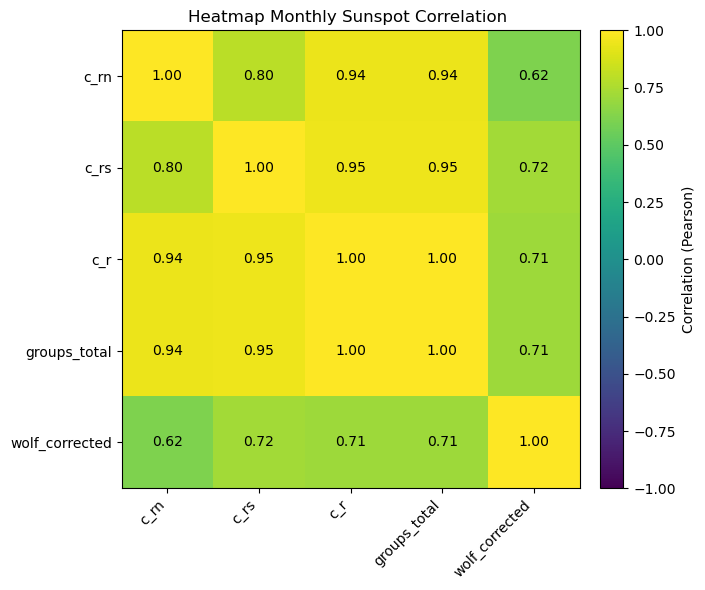

In [68]:
heat = (
    df.set_index('date')
      .resample('M')
      .agg({
          'c_rn': 'sum',        
          'c_rs': 'sum',       
          'c_r': 'sum',          
          'groups_total': 'sum', 
          wolf_col: 'mean'       
      })
)

heat = heat.dropna(how='all')
corr = heat.corr()

labels = corr.columns.tolist()
fig, ax = plt.subplots(figsize=(7,6))
im = ax.imshow(corr.values, vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels)


cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation (Pearson)')

for i in range(len(labels)):
    for j in range(len(labels)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}",
                ha='center', va='center')

ax.set_title('Heatmap Monthly Sunspot Correlation ')
plt.tight_layout()
plt.savefig('Heatmap_Sunspot.jpg', dpi=300) 
plt.show()

In [69]:
correlation_matrix = solarData[numeric_columns].corr()
print(correlation_matrix)

          c_rn      c_rs       c_r      wolf
c_rn  1.000000 -0.564677  0.076566  0.071182
c_rs -0.564677  1.000000  0.008699 -0.006061
c_r   0.076566  0.008699  1.000000  0.963700
wolf  0.071182 -0.006061  0.963700  1.000000


C:\Users\georgi.petrov\AppData\Local\Temp\ipykernel_24560\3944154937.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['wolf_corrected']


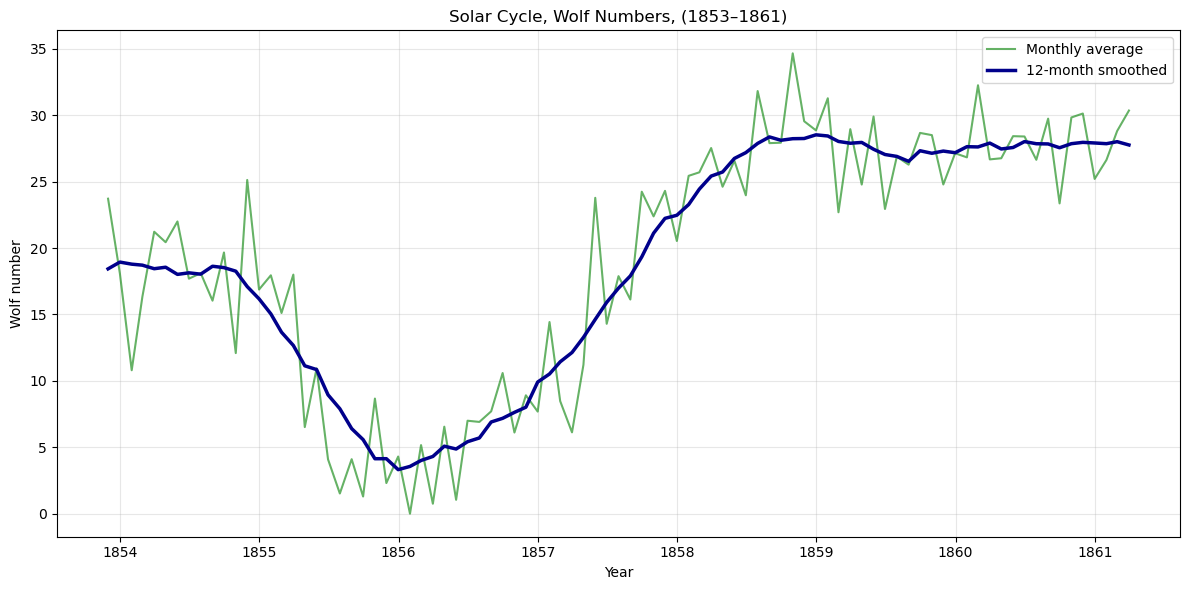

In [70]:
monthly_wolf = (
    solarData.set_index('date')
             .resample('M')['wolf_corrected']
             .mean()
)

# --- apply 12-month rolling average ---
smooth_wolf = monthly_wolf.rolling(window=12, center=True, min_periods=6).mean()

# --- plot ---
plt.figure(figsize=(12,6))
plt.plot(monthly_wolf.index, monthly_wolf, color='green', alpha=0.6, label='Monthly average')
plt.plot(smooth_wolf.index, smooth_wolf, color='darkblue', linewidth=2.5, label='12-month smoothed')

plt.title("Solar Cycle, Wolf Numbers, (1853–1861)")
plt.xlabel("Year")
plt.ylabel("Wolf number")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('SmutedSolarCycle.jpg', dpi=300) 
plt.show()

In [71]:
solarData['wolf'].describe()


count    3450.000000
mean       12.472464
std        28.547559
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       184.000000
Name: wolf, dtype: float64

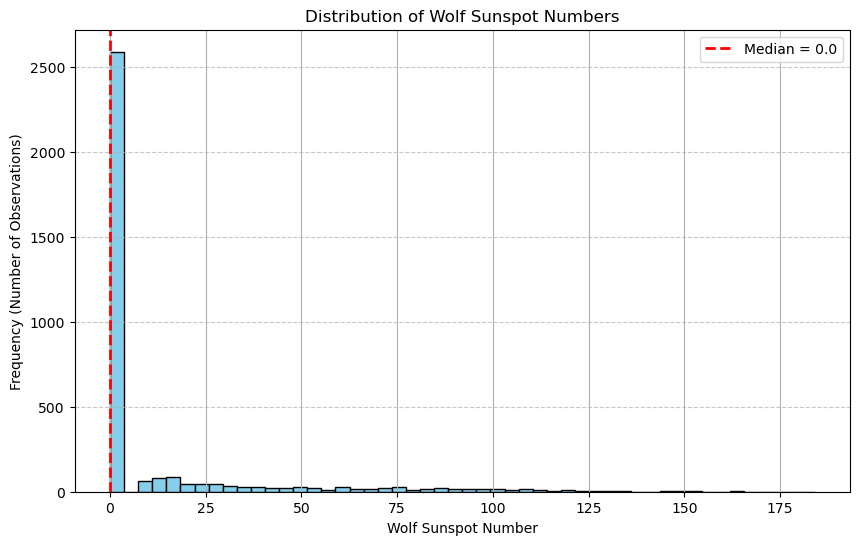

In [72]:
plt.figure(figsize=(10,6))
solarData['wolf'].hist(bins=50, color='skyblue', edgecolor='black')

plt.xlabel("Wolf Sunspot Number")
plt.ylabel("Frequency (Number of Observations)")
plt.title("Distribution of Wolf Sunspot Numbers")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add median line
median_val = solarData['wolf'].median()
plt.axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Median = {median_val:.1f}')
plt.legend()
plt.savefig('Wofl_sunspots_distribution.jpg', dpi=300) 

plt.show()

# наблюдаваме пик близо до 0:
повечето наблюдения имат число на Волф, близко до 0, което означава, че в много дни е имало много ниска или никаква слънчевопетнова активност.
# Дълга дясна опашка:
има по-малко дни с високи числа на Волф, но те се срещат — до около 175 във вашите данни.
# Силно асиметрично разпределение:
типично за броя на слънчевите петна — слънчевият цикъл има много тихи дни и по-малко на брой много активни дни.

# ще се опитаме да плотнем някаква графика, като първо ще ни трябва да групираме по години

In [73]:
solarData['date'] = pd.to_datetime(solarData['date'], errors='coerce')

# ще създадем нова колона в която ше съхраняваме годините на измерването

In [74]:
solarData['year'] = solarData['date'].dt.year

In [75]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'wolf_expected', 'wolf_diff',
       'wolf_alt', 'wolf_check', 'wolf_corrected', 'groups_total', 'year'],
      dtype='object')

In [76]:
solarData_fullDataSet = solarData.copy()

In [77]:
solarData_fullDataSet.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'wolf_expected', 'wolf_diff',
       'wolf_alt', 'wolf_check', 'wolf_corrected', 'groups_total', 'year'],
      dtype='object')

In [78]:
solarData_annual = (
    solarData_fullDataSet
    .groupby('year')
    .sum(numeric_only=True)
    .reset_index()
)

In [79]:
print(solarData_annual)

     year      no  c_rn  c_rs    c_r     wolf  invalid_date  wolf_expected  \
0  1853.0     229   218   164    382    436.0             0           4202   
1  1854.0    9419  1572  1008   2692   3067.0             0          28492   
2  1855.0    7669   682   553   1235   1184.0             0          13585   
3  1856.0    9475   327   663    990    972.0             0          10890   
4  1857.0   53435  1896  2359   4255   4712.0             0          46805   
5  1858.0  129280  2246  5842   8088   7133.0             0          88968   
6  1859.0  212433  3262  3630   6828   6230.0             0          75748   
7  1860.0  846709  9147  9051  18198  16307.0             0         200178   
8  1861.0  189236  1783  1822   3605   2807.0             0          39655   

   wolf_diff  wolf_alt  wolf_check  wolf_corrected  groups_total  
0    -3766.0       764      -328.0           600.0           382  
1   -25425.0      5272     -2205.0          4236.0          2580  
2   -12401.0      

In [80]:
#sunSpot_groups = solarData.groupby('year')[['c_rn', 'c_rs', 'c_r']].sum().reset_index()
sunSpot_groups = solarData_annual.groupby('year')[['c_rn', 'c_rs', 'c_r', 'wolf']].sum().reset_index()

In [81]:
print(sunSpot_groups)

     year  c_rn  c_rs    c_r     wolf
0  1853.0   218   164    382    436.0
1  1854.0  1572  1008   2692   3067.0
2  1855.0   682   553   1235   1184.0
3  1856.0   327   663    990    972.0
4  1857.0  1896  2359   4255   4712.0
5  1858.0  2246  5842   8088   7133.0
6  1859.0  3262  3630   6828   6230.0
7  1860.0  9147  9051  18198  16307.0
8  1861.0  1783  1822   3605   2807.0


In [82]:
solarData_fullDataSet.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'wolf_expected', 'wolf_diff',
       'wolf_alt', 'wolf_check', 'wolf_corrected', 'groups_total', 'year'],
      dtype='object')

In [83]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'wolf_expected', 'wolf_diff',
       'wolf_alt', 'wolf_check', 'wolf_corrected', 'groups_total', 'year'],
      dtype='object')

In [84]:
solarData.head(5)

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date,wolf_expected,wolf_diff,wolf_alt,wolf_check,wolf_corrected,groups_total,year
0,1853-11-09,1,N,11,0,11,22.0,NaN,9 Nov 1853,False,121,-99.0,22,0.0,22.0,11,1853.0
1,1853-11-17,1,N,11,0,0,0.0,NaN,17 Nov 1853,False,110,-110.0,11,-11.0,11.0,11,1853.0
2,1853-11-17,2,N,11,0,22,28.0,NaN,17 Nov 1853,False,132,-104.0,33,-5.0,28.0,11,1853.0
3,1853-11-21,2,N,14,0,14,20.0,NaN,21 Nov 1853,False,154,-134.0,28,-8.0,20.0,14,1853.0
4,1853-11-23,3,S,0,12,12,38.0,NaN,23 Nov 1853,False,132,-94.0,24,14.0,38.0,12,1853.0


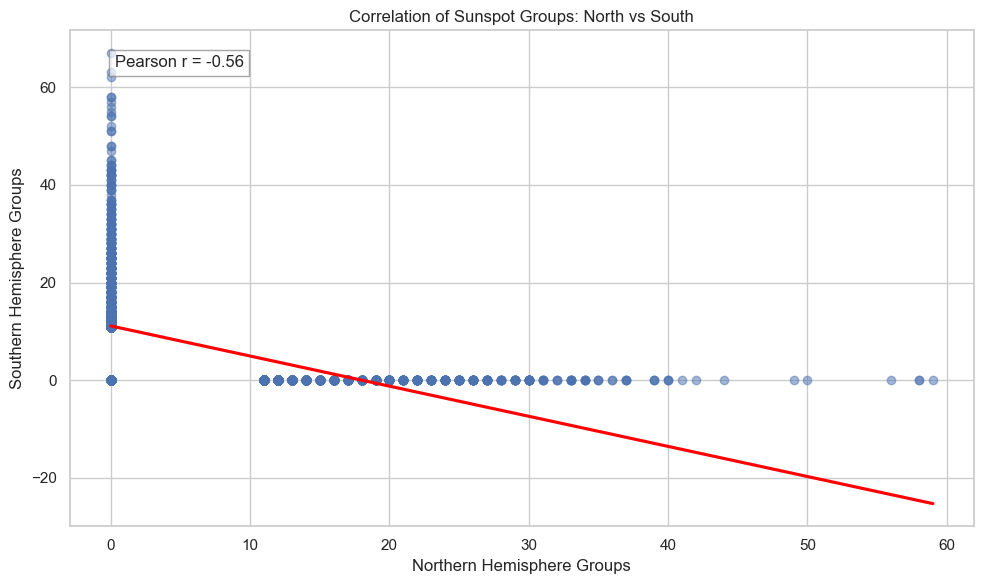

In [85]:
plot_graphs(
    df=solarData,
    plot_type='scatter',
    x_col='c_rn',
    y_col='c_rs',
    regression=True,
    title='Correlation of Sunspot Groups: North vs South',
    xlabel='Northern Hemisphere Groups',
    ylabel='Southern Hemisphere Groups',
    show_corr=True
)

# Scatter показващ броя на групите на слънчевите петна в северното полукълбо (c_rn) по оста X и броя на групите в южното полукълбо (c_rs) по оста Y, и 
# линия показваща регресията

Наблюдаваме отрицателна корелация (Пирсън r = -0.56)
Коефициентът на корелация на Пирсън -0.56 показва умерена отрицателна връзка между броя на групите слънчеви петна в северното и южното полукълбо.

С други думи — когато броят на групите на север се увеличава, броят на групите на юг има тенденция да намалява, и обратно.

Разпределение на точките
Повечето точки са струпани близо до x = 0 (малък брой групи на север) или y = 0 (малък брой групи на юг).
Това предполага, че много от наблюденията имат активност, концентрирана в едно от полукълбата в даден момент.

Линия на регресията
Регресионната линия има отрицателен наклон, в съответствие с отрицателната корелация.
Наклонът ѝ показва колко средно намалява броят на групите в южното полукълбо при увеличаване на броя в северното.

Възможна причина:
Активността на слънчевите петна често премества доминацията между полукълбата през слънчевите цикли — 
понякога северът е по-активен, понякога югът.

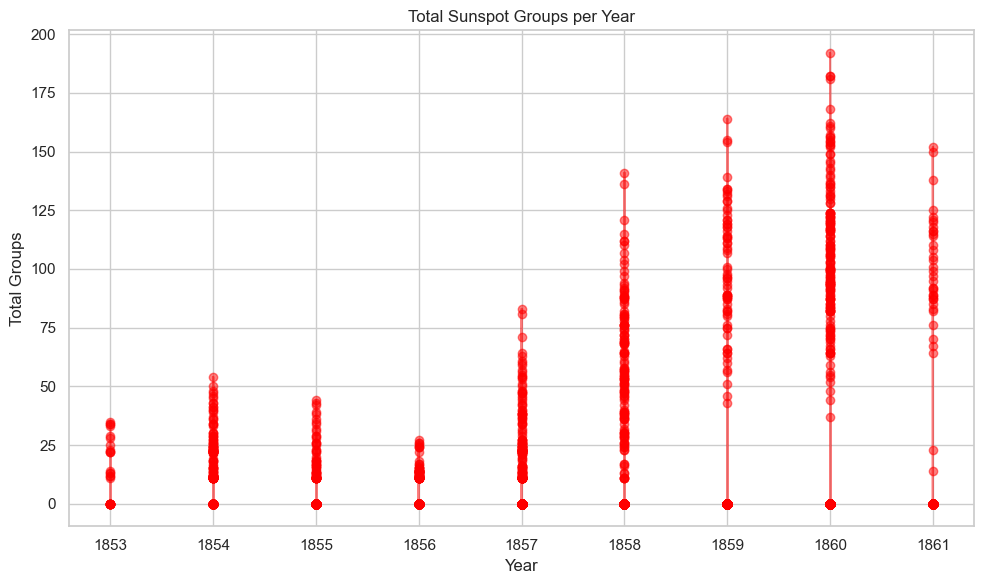

In [86]:
plot_graphs(
    df=solarData,
    plot_type='line',
    x_col='year',
    y_col='c_r',
    title='Total Sunspot Groups per Year',
    xlabel='Year',
    ylabel='Total Groups'
)

In [87]:
solarData = solarData.groupby('year')[['c_rn','c_rs','c_r']].sum().reset_index()
print(solarData)

     year  c_rn  c_rs    c_r
0  1853.0   218   164    382
1  1854.0  1572  1008   2692
2  1855.0   682   553   1235
3  1856.0   327   663    990
4  1857.0  1896  2359   4255
5  1858.0  2246  5842   8088
6  1859.0  3262  3630   6828
7  1860.0  9147  9051  18198
8  1861.0  1783  1822   3605


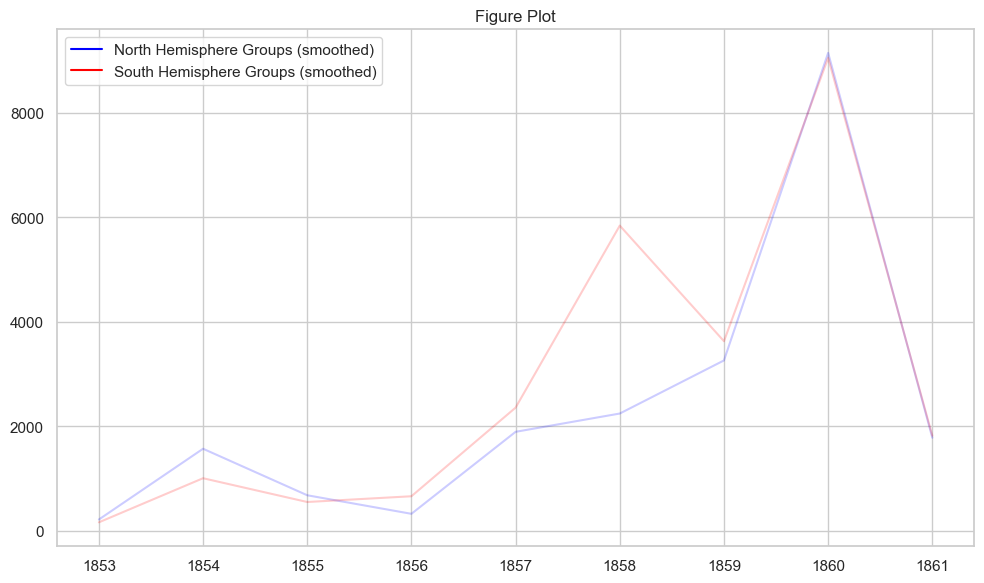

In [88]:
def hemisphere_time_series(data, window=12):
    smooth_north = data['c_rn'].rolling(window=window, center=True).mean()
    smooth_south = data['c_rs'].rolling(window=window, center=True).mean()

    plt.plot(data['year'], smooth_north, label='North Hemisphere Groups (smoothed)', color='blue')
    plt.plot(data['year'], smooth_south, label='South Hemisphere Groups (smoothed)', color='red')

    # 
    plt.plot(data['year'], data['c_rn'], color='blue', alpha=0.2)
    plt.plot(data['year'], data['c_rs'], color='red', alpha=0.2)

    plt.legend()
    plt.ylabel('Groups')
    plt.xlabel('Year')
    plt.title(f'Hemisphere Sunspot Groups Over Time (Smoothed {window} pts)')
    plt.grid(True)

plot_graphs(
    solarData,
    plot_type='figure',
    custom_plot_func=lambda df: hemisphere_time_series(df, window=12)
)

In [89]:
solarData.columns

Index(['year', 'c_rn', 'c_rs', 'c_r'], dtype='object')

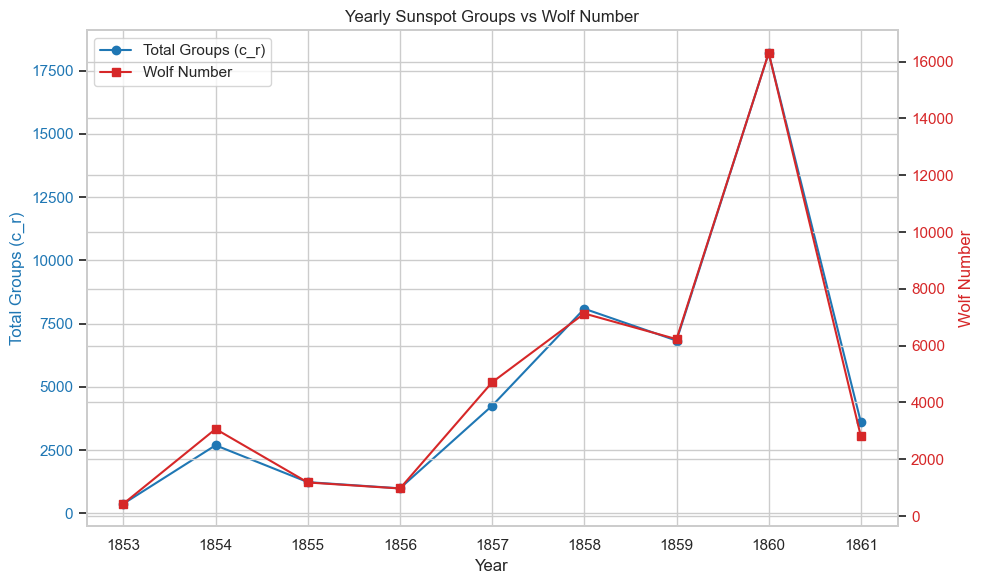

In [90]:
def plot_wolf_vs_cr(data):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot total groups (c_r) on left y-axis
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Total Groups (c_r)", color="tab:blue")
    ax1.plot(data['year'], data['c_r'], color="tab:blue", marker='o', label="Total Groups (c_r)")
    ax1.tick_params(axis='y', labelcolor="tab:blue")

    # Second y-axis for Wolf numbers
    ax2 = ax1.twinx()
    ax2.set_ylabel("Wolf Number", color="tab:red")
    ax2.plot(data['year'], data['wolf'], color="tab:red", marker='s', label="Wolf Number")
    ax2.tick_params(axis='y', labelcolor="tab:red")

    # Titles & legends
    plt.title("Yearly Sunspot Groups vs Wolf Number")
    fig.tight_layout()

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.grid(True, which='both', axis='x', linestyle='--', alpha=0.6)
    plt.savefig('YearlySunSpots_vs_Wofl.jpg', dpi=300) 
    plt.show()

# Run it
plot_wolf_vs_cr(sunSpot_groups)

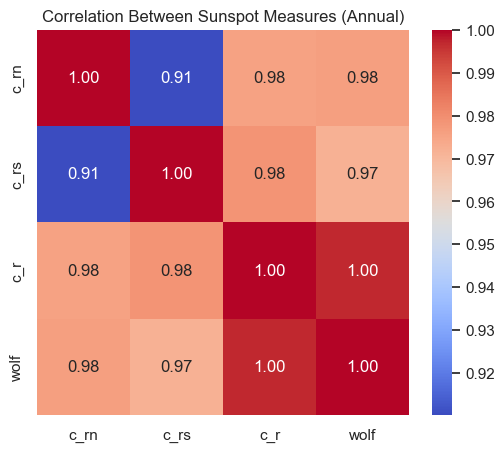

In [91]:
plt.figure(figsize=(6,5))
sns.heatmap(sunSpot_groups[['c_rn','c_rs','c_r','wolf']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Sunspot Measures (Annual)")
plt.show()

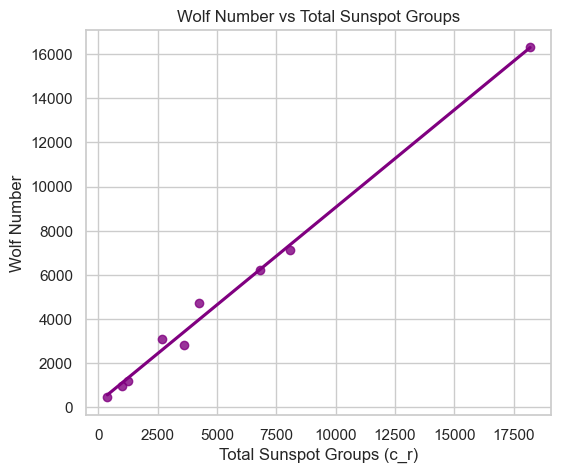

In [92]:
plt.figure(figsize=(6,5))
sns.regplot(data=sunSpot_groups, x='c_r', y='wolf', ci=None, color='purple')
plt.xlabel("Total Sunspot Groups (c_r)")
plt.ylabel("Wolf Number")
plt.title("Wolf Number vs Total Sunspot Groups")
plt.show()

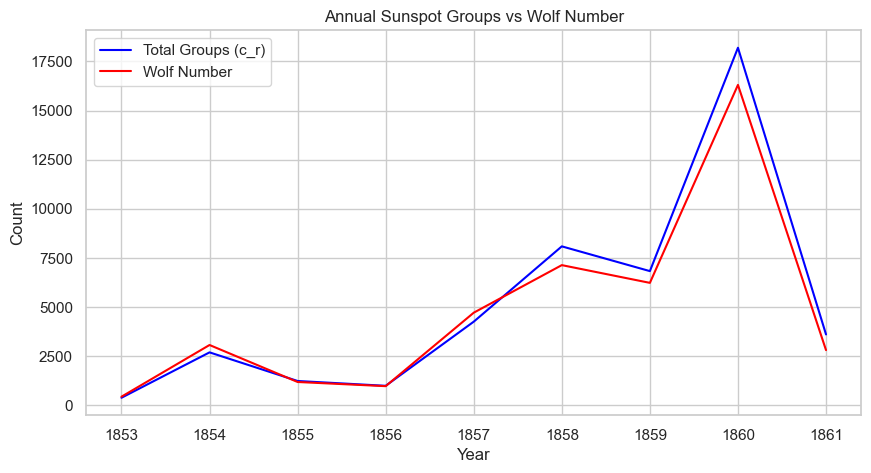

In [93]:
plt.figure(figsize=(10,5))
plt.plot(sunSpot_groups['year'], sunSpot_groups['c_r'], label='Total Groups (c_r)', color='blue')
plt.plot(sunSpot_groups['year'], sunSpot_groups['wolf'], label='Wolf Number', color='red')
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Annual Sunspot Groups vs Wolf Number")
plt.legend()
plt.grid(True)
plt.show()

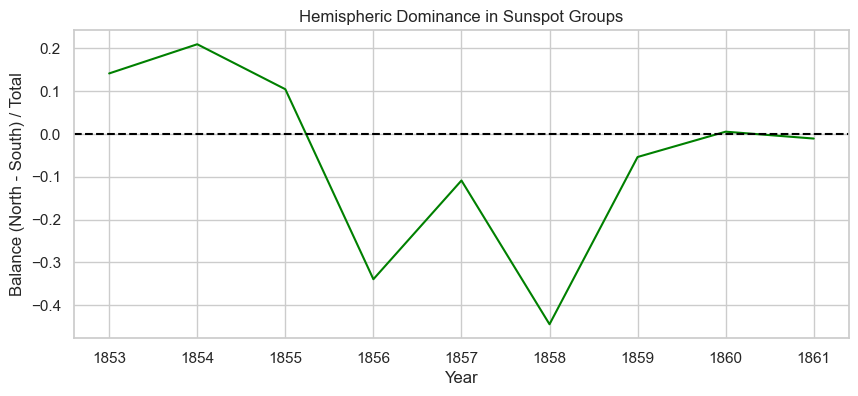

In [94]:
sunSpot_groups['hemisphere_balance'] = (sunSpot_groups['c_rn'] - sunSpot_groups['c_rs']) / sunSpot_groups['c_r']

plt.figure(figsize=(10,4))
plt.plot(sunSpot_groups['year'], sunSpot_groups['hemisphere_balance'], color='green')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Year")
plt.ylabel("Balance (North - South) / Total")
plt.title("Hemispheric Dominance in Sunspot Groups")
plt.grid(True)
plt.show()

In [95]:
summary_stats = sunSpot_groups.describe().T  # .T transposes for better view
summary_stats['median'] = sunSpot_groups.median()
summary_stats = summary_stats[['mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max']]

summary_stats

,mean,median,std,min,25%,50%,75%,max
year,1857.0,1857.0,2.738613,1853.0,1855.0,1857.0,1859.0,1861.0
c_rn,2348.111111,1783.0,2729.349806,218.0,682.0,1783.0,2246.0,9147.0
c_rs,2788.0,1822.0,2956.832596,164.0,663.0,1822.0,3630.0,9051.0
c_r,5141.444444,3605.0,5548.576802,382.0,1235.0,3605.0,6828.0,18198.0
wolf,4760.888889,3067.0,4919.879176,436.0,1184.0,3067.0,6230.0,16307.0
hemisphere_balance,-0.055215,-0.010818,0.216537,-0.444609,-0.108813,-0.010818,0.104453,0.20951


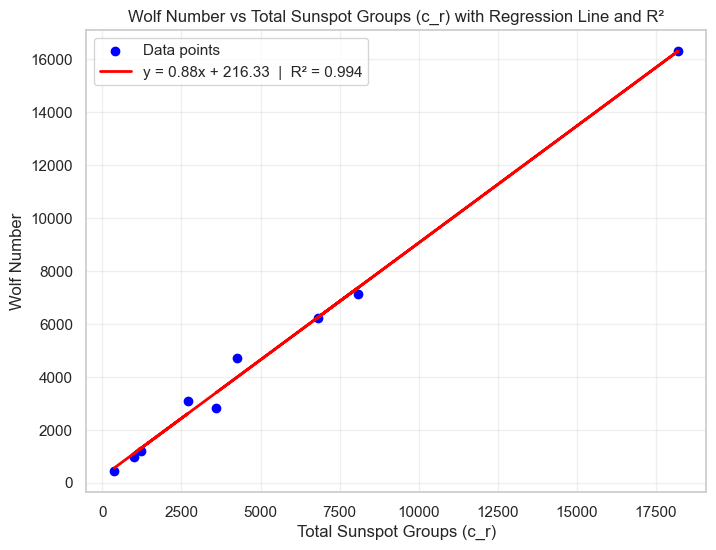

In [96]:
def plot_regression_with_r2(x, y, xlabel, ylabel):
    # Reshape data for sklearn
    X = np.array(x).reshape(-1, 1)
    Y = np.array(y)

    # Fit regression model
    model = LinearRegression()
    model.fit(X, Y)

    # Predictions
    y_pred = model.predict(X)

    # Equation & R²
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(X, Y)  # R² value
    equation = f"y = {slope:.2f}x + {intercept:.2f}  |  R² = {r2:.3f}"

    # Plot scatter
    plt.figure(figsize=(8,6))
    plt.scatter(X, Y, color="blue", label="Data points")

    # Plot regression line
    plt.plot(X, y_pred, color="red", linewidth=2, label=equation)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title(f"{ylabel} vs {xlabel} with Regression Line and R²")
    plt.show()

# Example with your data
plot_regression_with_r2(
    sunSpot_groups['c_r'], 
    sunSpot_groups['wolf'], 
    xlabel="Total Sunspot Groups (c_r)", 
    ylabel="Wolf Number"
)

In [97]:
solarData_fullDataSet.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'wolf_expected', 'wolf_diff',
       'wolf_alt', 'wolf_check', 'wolf_corrected', 'groups_total', 'year'],
      dtype='object')

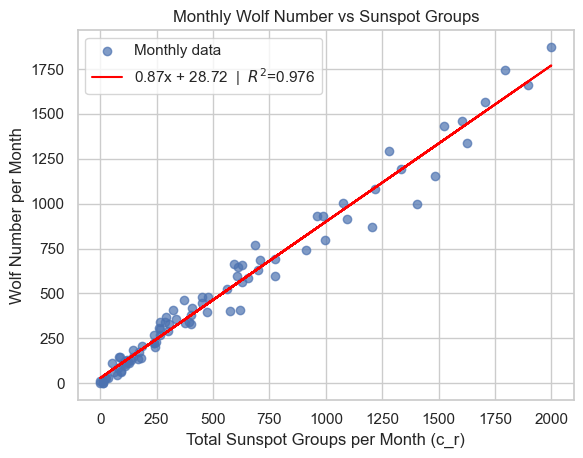

In [98]:
# Ensure date column is datetime
solarData_fullDataSet['date'] = pd.to_datetime(solarData_fullDataSet['date'])

# Group by year and month
monthly_data = (
    solarData_fullDataSet
    .groupby([solarData_fullDataSet['date'].dt.to_period('M')])[['c_r', 'wolf']]
    .sum()
    .reset_index()
)

# Convert Period to timestamp
monthly_data['date'] = monthly_data['date'].dt.to_timestamp()

# Prepare X and y
X = monthly_data[['c_r']].values
y = monthly_data['wolf'].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# R² score
r2 = model.score(X, y)

# Plot
plt.scatter(X, y, label='Monthly data', alpha=0.7)
plt.plot(X, y_pred, color='red',
         label=f'{model.coef_[0]:.2f}x + {model.intercept_:.2f}  |  $R^2$={r2:.3f}')
plt.xlabel('Total Sunspot Groups per Month (c_r)')
plt.ylabel('Wolf Number per Month')
plt.title('Monthly Wolf Number vs Sunspot Groups')
plt.legend()
plt.grid(True)
plt.savefig('WolfVsSunSpots.jpg', dpi=300) 
plt.show()


In [99]:
# 1) Visual: residuals vs fitted
plt.scatter(yhat, resid, alpha=0.7)
plt.axhline(0, ls='--')
plt.xlabel('Fitted'); plt.ylabel('Residuals'); plt.title('Residuals vs Fitted')
plt.grid(True, alpha=0.3); plt.show()

# 2) Breusch–Pagan (tests variance ~ function of X)
exog = sm.add_constant(X)
bp_stat, bp_p, f_stat, f_p = het_breuschpagan(resid, exog)
print(f"Breusch–Pagan: LM={bp_stat:.2f}, p={bp_p:.3f} | F={f_stat:.2f}, p={f_p:.3f}")

# 3) White test (more general form)
w_stat, w_p, wf_stat, wf_p = het_white(resid, exog)
print(f"White test: LM={w_stat:.2f}, p={w_p:.3f} | F={wf_stat:.2f}, p={wf_p:.3f}")

# 4) Nonparametric: is |resid| related to fitted?
rho, p = spearmanr(np.abs(resid), yhat)
print(f"Spearman(|resid|, fitted): rho={rho:.2f}, p={p:.3f}")

# 5) Variance across fitted bins (Levene)
q = pd.qcut(yhat, 4, labels=False, duplicates='drop')
groups = [resid[q==i] for i in np.unique(q)]
W, pL = levene(*groups, center='median')
print(f"Levene across fitted quartiles: W={W:.2f}, p={pL:.3f}")

NameError: name 'yhat' is not defined

Всяка синя точка представлява един месец обобщени данни за слънчевата активност.

Х-ос: Общият брой групи слънчеви петна (c_r), наблюдавани през този месец.
Y-ос: Съответният месечен брой на Волф (традиционен индекс за слънчева активност).

Линeйна регресия -> най-добре пасващата линейна регресия:

Наклон (0.87): За всяка допълнителна група слънчеви петна в рамките на месец, броят на Волф нараства средно с около 0.87 единици.
Отсечка (28.72): Дори при 0 групи слънчеви петна, броят на Волф ще е около 29. Тази базова стойност идва от начина, по който се изчислява индексът на Волф (той включва и броя на отделните петна, а не само групите).

Стойност на R² (0.976) = 0.976 означава, че 97.6% от изменението в числото на Волф може да се обясни чрез изменението в броя на групите слънчеви петна. Това е изключително силна линейна връзка — c_r и Wolf са почти перфектно корелирани.

Интерпретация:
Можем да кажем, че числото на Волф може да бъде предсказано с висока точност само от броя на групите слънчеви петна.
Малкото разсейване около линията вероятно идва от разликите в броя на отделните петна във всяка група, които са вкл'чени в числото на Wolf, но c_r не.

# Няколко думи като резюме и обосновка на данните които наблюдавахме за слънчевите петна и групирането им в групи

-> Връзка между активността на хемисферите:
Корелацията между групите в Северното полукълбо (c_rn) и групите в Южното полукълбо (c_rs) е отрицателна (r  -0.56)

Това показва, че през наблюдаваните години, когато едно полукълбо става по-активно, другото обикновено е по-малко активно.
Това редуване е съвместимо с известното поведение на слънчевия цикъл, при което активността на слънчевите петна преминава от едно полукълбо към другото с течение на времето.

-> Връзка между общия брой групи и числото на Волф
Общият брой групи (c_r) и числото на Волф (wolf) имат изключително висока корелация (r ≈ 0.96).
Регресионният анализ потвърждава, че над 97% от вариациите в числата на Волф могат да се обяснят само чрез броя на групите слънчеви петна.
Малки отклонения от линията се дължат на факта, че формулата на Волф включва отделни слънчеви петна, а не само групи.

-> Разпределение на числата на Волф
Повечето стойности на Волф са нула или близки до нула (медиана = 0), което означава, че много дни имат малка или никаква активност на слънчевите петна.
Съществува асиметрична дълга дясна опашка до 184, която представлява редки, но изключително активни дни.
Това асиметрично разпределение съответства на модела на слънчевия цикъл — дълги спокойни фази и кратки изблици на висока активност.

-> Тенденции на активността във времето
Годишната агрегация показва големи колебания в общата активност на слънчевите петна.
Пиковите години (например 1860) имат порядъци повече групи и стойности на Волф в сравнение с минималните години (например 1853, 1856).
Това е отличителен белег на ~11-годишния слънчев цикъл, който можем да видим дори в този частичен набор от данни.

-> Качество и пълнота на данните
Колоната invalid_date е нула за всички години — което предполага, че наборът от данни е чист по отношение на обработката на датите.

Въпреки това, липсващи данни могат да съществуват на по-кратки времеви интервали (месеци/дни), затова е необходимо внимателно боравене със стойности NaN при моделирането.

Крайни бележки
Наборът от данни силно подкрепя известните модели в слънчевата физика: редуване на активността между хемисферите, силна линейна връзка между броя на групите и числата на Волф, както и циклично покачване и спад на активността.

In [ ]:
monthly_data = (
    solarData_fullDataSet
    .groupby([solarData_fullDataSet['date'].dt.to_period('M')])
    .agg({'c_r':'sum', 'wolf':'mean'})
    .reset_index()
)
monthly_data['date'] = monthly_data['date'].dt.to_timestamp()

In [ ]:
monthly_sum = (
    solarData_fullDataSet
    .groupby([solarData_fullDataSet['date'].dt.to_period('M')])[['c_r','wolf']]
    .sum()
    .reset_index()
)
monthly_sum['date'] = monthly_sum['date'].dt.to_timestamp()

X_sum = monthly_sum[['c_r']].values
y_sum = monthly_sum['wolf'].values

model_sum = LinearRegression().fit(X_sum, y_sum)
y_pred_sum = model_sum.predict(X_sum)
r2_sum = model_sum.score(X_sum, y_sum)

# --- Version B: sum spots, mean Wolf ---
monthly_mix = (
    solarData_fullDataSet
    .groupby([solarData_fullDataSet['date'].dt.to_period('M')])
    .agg({'c_r':'sum', 'wolf':'mean'})
    .reset_index()
)
monthly_mix['date'] = monthly_mix['date'].dt.to_timestamp()

X_mix = monthly_mix[['c_r']].values
y_mix = monthly_mix['wolf'].values

model_mix = LinearRegression().fit(X_mix, y_mix)
y_pred_mix = model_mix.predict(X_mix)
r2_mix = model_mix.score(X_mix, y_mix)

# --- Plot both ---
fig, axes = plt.subplots(1,2, figsize=(14,6), sharey=True)

# A: sum vs sum
axes[0].scatter(X_sum, y_sum, alpha=0.7, label="Monthly data")
axes[0].plot(X_sum, y_pred_sum, color='red',
             label=f"{model_sum.coef_[0]:.2f}x+{model_sum.intercept_:.2f} | $R^2$={r2_sum:.3f}")
axes[0].set_title("Version A: SUM(c_r), SUM(wolf)")
axes[0].set_xlabel("Total Sunspots per Month (c_r)")
axes[0].set_ylabel("Wolf Number per Month")
axes[0].legend()
axes[0].grid(True, alpha=0.4)

# B: sum spots, mean Wolf
axes[1].scatter(X_mix, y_mix, alpha=0.7, label="Monthly data")
axes[1].plot(X_mix, y_pred_mix, color='red',
             label=f"{model_mix.coef_[0]:.2f}x+{model_mix.intercept_:.2f} | $R^2$={r2_mix:.3f}")
axes[1].set_title("Version B: SUM(c_r), MEAN(wolf)")
axes[1].set_xlabel("Total Sunspots per Month (c_r)")
axes[1].legend()
axes[1].grid(True, alpha=0.4)

plt.suptitle("Impact of Aggregation Method on Wolf vs Sunspots Regression")
plt.tight_layout()
plt.show()

In [ ]:
solarData.columns

In [ ]:
df = solarData_fullDataSet.copy()
df['groups_total'] = df['c_rn'].fillna(0) + df['c_rs'].fillna(0)

monthly = (
    df.set_index('date')
      .resample('M')
      .agg({'groups_total':'mean', 'c_r':'mean', 'wolf':'mean'})
)

monthly['wolf_expected'] = monthly['groups_total'] + monthly['c_r']

plt.scatter(monthly['wolf_expected'], monthly['wolf'])

In [ ]:
# X = monthly mean of (groups_total + c_r)
X = monthly['wolf_expected'].values.reshape(-1,1)   # your computed formula
y = monthly['wolf'].values                          # reported Wolf number

# Fit regression
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# R²
r2 = model.score(X, y)

# Plot
plt.figure(figsize=(7,6))
plt.scatter(X, y, alpha=0.7, label="Monthly data")
plt.plot(X, y_pred, color='red', linewidth=2,
         label=f"{model.coef_[0]:.2f}x + {model.intercept_:.2f}  |  $R^2$={r2:.3f}")
plt.xlabel("groups_total, Monthly")
plt.ylabel("Wolf, Monthly" )
plt.title("Wolf vs. groups, Monthly")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('WolfVsSunSpots_regression.jpg', dpi=300) 
plt.show()

In [ ]:
# X = monthly['groups_total'].values.reshape(-1,1)
# y = monthly_wolf.values  # monthly mean Wolf
model = LinearRegression().fit(X, y)
yhat = model.predict(X)
resid = y - yhat

print("Residual mean (≈0):", resid.mean())
print("Residual median (≈0):", np.median(resid))
print("Above line:", (resid>0).sum(), "Below line:", (resid<0).sum())
print("Residual vs x correlation (should be ~0 if no pattern):",
      np.corrcoef(resid, X.squeeze())[0,1])

In [ ]:
solarData.columns

In [ ]:
solarData.columns

In [ ]:
daily = (df_daily_src
         .groupby('date', as_index=False)[['c_rn','c_rs','c_r']]
         .sum(min_count=1))

north_obs = daily['c_rn'].notna()
south_obs = daily['c_rs'].notna()
both_obs  = north_obs & south_obs
spots_obs = daily['c_r'].notna()

pct_north_zero   = daily.loc[north_obs, 'c_rn'].eq(0).mean()*100
pct_south_zero   = daily.loc[south_obs, 'c_rs'].eq(0).mean()*100
pct_zero_strict  = daily.loc[both_obs, ['c_rn','c_rs']].sum(axis=1).eq(0).mean()*100
pct_zero_lenient = daily[['c_rn','c_rs']].fillna(0).sum(axis=1).eq(0).mean()*100
pct_zero_spots   = daily.loc[spots_obs, 'c_r'].eq(0).mean()*100

print(f"North zero-group days (observed): {pct_north_zero:.2f}%")
print(f"South zero-group days (observed): {pct_south_zero:.2f}%")
print(f"Zero groups (strict; both hemispheres observed): {pct_zero_strict:.2f}%")
print(f"Zero groups (lenient; NaN→0): {pct_zero_lenient:.2f}%")
print(f"Zero *spots* days (observed): {pct_zero_spots:.2f}%")

In [ ]:
n_north = daily['c_rn'].notna().sum()
n_south = daily['c_rs'].notna().sum()
n_both  = (daily['c_rn'].notna() & daily['c_rs'].notna()).sum()
n_spots = daily['c_r'].notna().sum()
print(n_north, n_south, n_both, n_spots)

In [ ]:
def get_daily_df():
    # (a) try a daily variable already in memory
    for name in ['solarData_fullDataSet', 'solar_daily', 'solarData_raw', 'solarData']:
        if name in globals():
            df = globals()[name].copy()
            # prefer an existing 'date' column
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'], errors='coerce')
                return df[df['date'].notna()]
            # if date is in index
            if isinstance(df.index, pd.DatetimeIndex):
                df = df.reset_index().rename(columns={df.index.name or 'index': 'date'})
                return df[df['date'].notna()]
            # parse from date_original if present
            if 'date_original' in df.columns:
                df['date'] = pd.to_datetime(df['date_original'], errors='coerce')
                return df[df['date'].notna()]
    # (b) reload from disk if nothing usable is in memory
    path = r"C:\Users\georgi.petrov\DataScience\00.ExamProject\data\Teague_Table.csv"
    raw = pd.read_csv(path, encoding="ISO-8859-1", on_bad_lines="skip")
    # rename to your cleaned schema
    raw = raw.rename(columns={
        'Date':'date_original','No.':'no','N / S':'n_s',
        'C / Rn':'c_rn','C / Rs':'c_rs','C / R':'c_r',
        'Wolf':'wolf','Notes':'notes'
    })
    raw['date'] = pd.to_datetime(raw['date_original'], errors='coerce')
    return raw.dropna(subset=['date'])

df = get_daily_df().sort_values('date')

# --- 1) choose Wolf series ---
if 'wolf_corrected' in df.columns:
    wolf_col = 'wolf_corrected'
else:
    # fallback: use reported wolf if present else groups+spots
    if 'wolf' not in df.columns:
        df['wolf'] = np.nan
    if not set(['c_rn','c_rs','c_r']).issubset(df.columns):
        raise KeyError("Missing c_rn/c_rs/c_r; cannot build fallback Wolf.")
    wolf_alt = df[['c_rn','c_rs','c_r']].fillna(0).sum(axis=1)
    df['wolf_use'] = df['wolf'].where(df['wolf'].notna() & (df['wolf']>0), wolf_alt)
    wolf_col = 'wolf_use'

# --- 2) collapse per day (mean; index-like) ---
daily = df.groupby('date')[wolf_col].mean().rename('Wolf_Daily').dropna()

# --- 3) monthly & yearly means ---
monthly = daily.resample('M').mean().rename('Wolf_MonthlyMean')
yearly  = daily.resample('Y').mean().rename('Wolf_YearlyMean')

# --- 4) 13-month smoothed monthly (1/24, 11×1/12, 1/24) ---
w = np.array([1/24] + [1/12]*11 + [1/24])
sm_vals = np.convolve(monthly.values, w, mode='same')
smooth13 = pd.Series(sm_vals, index=monthly.index, name='Wolf_13mSmoothed')
smooth13.iloc[:6] = np.nan; smooth13.iloc[-6:] = np.nan  # trim edge artifacts

# --- 5) plot like your example ---
plt.figure(figsize=(14,5))
plt.plot(daily.index,   daily.values,   linewidth=0.9, color='gold',   alpha=0.35, label='Daily')
plt.plot(monthly.index, monthly.values, linewidth=1.2, color='green',              label='Monthly Mean')
plt.plot(smooth13.index,smooth13.values,linewidth=1.2, color='red',               label='13-month Smoothed')
plt.plot(yearly.index,  yearly.values,  linewidth=1.2, color='blue',         label='Yearly Mean')
plt.title("Sunspot Numbers: Daily, Monthly, Monthly Smoothed , Yearly")
plt.xlabel("Year"); plt.ylabel("Sunspot (Wolf) Number")
plt.savefig('SunSpotsAllInOne.jpg', dpi=300) 
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
df = solarData.copy()  # <- your yearly table: ['year','c_rn','c_rs','c_r', ...]
# Build features
df['groups_total'] = df[['c_rn','c_rs']].sum(axis=1, min_count=1)

# Pick a Wolf-like column if present, else make a proxy (groups + spots)
if 'wolf_corrected' in df.columns:
    wolf_col = 'wolf_corrected'
elif 'wolf' in df.columns:
    wolf_col = 'wolf'
else:
    df['wolf_proxy'] = df['groups_total'].fillna(0) + df['c_r'].fillna(0)
    wolf_col = 'wolf_proxy'

feat_yearly = df[['c_rn','c_rs','c_r','groups_total', wolf_col]].rename(columns={wolf_col:'wolf'})
corr_yearly = feat_yearly.corr()
print(corr_yearly.round(3))

In [ ]:
def get_daily_df():
    for name in ['solarData_fullDataSet', 'solarData']:
        if name in globals():
            df = globals()[name].copy()
            # a) 'date' exists
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'], errors='coerce')
                return df[df['date'].notna()]
            # b) date is in the index
            if isinstance(df.index, pd.DatetimeIndex):
                df = df.reset_index().rename(columns={df.index.name or 'index':'date'})
                return df[df['date'].notna()]
            # c) parse from date_original if present
            if 'date_original' in df.columns:
                df['date'] = pd.to_datetime(df['date_original'], errors='coerce')
                return df[df['date'].notna()]
    raise NameError("No daily dataframe with a 'date' column found (e.g. solarData_fullDataSet).")

solar_daily = get_daily_df().sort_values('date')

# -------- 2) Build features for the heatmap/matrix (monthly) --------
# counts → SUM per month; Wolf (index-like) → MEAN per month
solar_daily['groups_total'] = solar_daily['c_rn'].fillna(0) + solar_daily['c_rs'].fillna(0)
wolf_col = 'wolf_corrected' if 'wolf_corrected' in solar_daily.columns else 'wolf'

feat = (
    solar_daily.set_index('date')
    .resample('M')
    .agg({
        'c_rn': 'sum',
        'c_rs': 'sum',
        'c_r':  'sum',
        'groups_total': 'sum',
        wolf_col: 'mean'
    })
    .rename(columns={wolf_col: 'wolf'})
)

# -------- 3) (Optional) sanity checks that often explain "1.000" everywhere --------
print("groups_total == c_r  ?", feat['groups_total'].equals(feat['c_r']))
print("wolf identical to c_r?", feat['wolf'].equals(feat['c_r']))
print("max |groups_total - c_r|:", (feat['groups_total'] - feat['c_r']).abs().max())

# -------- 4) Correlation matrix to print (matches the heatmap if you plotted from `feat`) --------
corr = feat.corr()
print(corr.round(3))

In [ ]:
a, b = np.polyfit(feat['groups_total'].values, feat['c_r'].values, 1)
print(f"c_r ≈ {a:.3f} * groups_total + {b:.3f}")

In [ ]:
df = solar_daily.copy()  # daily dataframe with 'date', 'c_rn', 'c_rs'
monthly = (df.set_index('date')[['c_rn','c_rs']]
             .resample('M').sum())

roll_corr = monthly['c_rn'].rolling(24, min_periods=12).corr(monthly['c_rs'])

plt.figure(figsize=(10,3))
plt.plot(roll_corr.index, roll_corr.values)
plt.axhline(0, ls='--', alpha=0.4)
plt.title('Rolling N–S correlation (24-month window)')
plt.ylabel('corr(c_rn, c_rs)')
plt.tight_layout(); plt.show()

In [ ]:
monthly = (solar_daily.set_index('date')[['c_rn','c_rs']]
           .resample('M').sum())

def xcorr(a, b, max_lag=24, min_periods=12):
    """Cross-correlation for lags [-max_lag, max_lag]. Returns (Series, best_lag, peak_value)."""
    vals = {}
    for lag in range(-max_lag, max_lag + 1):
        r = a.shift(lag).corr(b, min_periods=min_periods)  # can be NaN
        vals[lag] = r
    xc = pd.Series(vals, dtype=float)
    if xc.dropna().empty:
        return xc, None, np.nan
    best_lag = xc.dropna().idxmax()        # use idxmax of non-NaN values
    peak_val = xc.loc[best_lag]
    return xc, best_lag, peak_val

xc, lag_at_peak, peak = xcorr(monthly['c_rn'], monthly['c_rs'], max_lag=24, min_periods=6)

# Print nicely without .round() on float
if np.isnan(peak) or lag_at_peak is None:
    print("Not enough overlapping data to compute cross-correlation.")
else:
    print(f"Peak cross-corr: {peak:.3f} at lag (months): {lag_at_peak}")
    # Interpretation: lag>0 ⇒ North leads South by 'lag' months; lag<0 ⇒ South leads

# Plot the cross-correlation function
plt.figure(figsize=(8,3))
plt.stem(xc.index, xc.values, use_line_collection=True)
plt.axhline(0, ls='--', alpha=0.4)
plt.title('Cross-correlation: North vs South (monthly sums)')
plt.xlabel('Lag (months) — positive: North leads'); plt.ylabel('corr')
plt.tight_layout(); plt.show()

In [ ]:
ai = (monthly['c_rn'] - monthly['c_rs']) / (monthly['c_rn'] + monthly['c_rs'])
ai = ai.replace([np.inf, -np.inf], np.nan)

plt.figure(figsize=(10,3))
plt.plot(ai.index, ai.values)
plt.axhline(0, ls='--', alpha=0.4)
plt.title('Hemispheric asymmetry index, (N−S)/(N+S)')
plt.ylabel('Asymmetry'); plt.tight_layout(); plt.show()

print("Fraction of months N>S:", (ai>0).mean().round(3))
print("Fraction of months S>N:", (ai<0).mean().round(3))

In [ ]:
df = solarData_fullDataSet.copy()  # or solarData; needs 'date','c_rn','c_rs','c_r'
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# daily groups and modern Wolf (k=1)
df['groups_total'] = df['c_rn'].fillna(0) + df['c_rs'].fillna(0)
df['W_modern'] = 10*df['groups_total'] + df['c_r'].fillna(0)

# monthly means (the F=16.7·W relation is typically quoted for monthly averages)
monthly = (df.set_index('date')[['W_modern']]
             .resample('M').mean()
             .dropna())

# implied area (cannot be validated without real area data)
monthly['F_implied_MSH'] = 16.7 * monthly['W_modern']
print(monthly.head())

In [ ]:
def monthly_W_from_counts(df):
    df = df.copy()
    # ensure a datetime 'date'
    if 'date' not in df.columns and isinstance(df.index, pd.DatetimeIndex):
        df = df.reset_index().rename(columns={df.index.name or 'index':'date'})
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])

    # daily totals (avoid overweighting days with multiple rows)
    daily = (df.groupby('date')[['c_rn','c_rs','c_r']]
               .sum(min_count=1))
    daily['G_daily'] = daily['c_rn'].fillna(0) + daily['c_rs'].fillna(0)
    daily['W_modern'] = 10*daily['G_daily'] + daily['c_r'].fillna(0)

    # monthly mean of W (index-like → mean)
    Wm = daily['W_modern'].resample('M').mean().rename('W_modern')
    return Wm

# pick your daily dataframe
Wm = monthly_W_from_counts(solarData_fullDataSet)  # or monthly_W_from_counts(solarData)

# ---- 2) Load a monthly area CSV (EDIT THE PATH) ----
# Expect either:
#   a) columns: 'date' (parsable), 'area_msh' (or 'area','MSH','total_area')
#   b) columns: 'year','month', plus area column
area_path = r"PATH\TO\your_area_file.csv"  # <-- change this
area_df = pd.read_csv(area_path)

# try to standardize to a monthly DatetimeIndex and an 'area_msh' series
cols_lower = {c: c.strip().lower() for c in area_df.columns}
area_df = area_df.rename(columns=cols_lower)

def pick_area_col(df):
    for c in ['area_msh','area','msh','total_area','sunspot_area']:
        if c in df.columns: return c
    raise KeyError("Could not find an area column (expected one of: area_msh, area, msh, total_area, sunspot_area).")

if 'date' in area_df.columns:
    area_df['date'] = pd.to_datetime(area_df['date'], errors='coerce')
    area_m = (area_df.dropna(subset=['date'])
                      .set_index('date')[pick_area_col(area_df)]
                      .astype(float)
                      .resample('M').mean())
else:
    # assume year/month integers
    if not {'year','month'}.issubset(area_df.columns):
        raise KeyError("Area file must have 'date' or ('year','month') columns.")
    area_df['date'] = pd.to_datetime(dict(year=area_df['year'].astype(int),
                                          month=area_df['month'].astype(int),
                                          day=1))
    area_m = (area_df.set_index('date')[pick_area_col(area_df)]
                     .astype(float)
                     .resample('M').mean())

area_m = area_m.rename('area_msh')

# ---- 3) Join & fit F = a * W + b ----
dat = pd.concat([Wm, area_m], axis=1).dropna()
if dat.empty:
    print("No overlapping months between your Wolf series and the area series. "
          "Your Wolf covers ~1853–1861; RGO areas start 1874. "
          "Use a later Wolf series (1874+) or a different area dataset with overlap.")
else:
    a, b = np.polyfit(dat['W_modern'].values, dat['area_msh'].values, 1)
    yhat = a*dat['W_modern'].values + b
    r2 = 1 - ((dat['area_msh'].values - yhat)**2).sum() / ((dat['area_msh'].values - dat['area_msh'].mean())**2).sum()
    print(f"F ≈ {a:.2f} · W + {b:.2f}   (R² = {r2:.3f})")
    print("If a ≈ 16.7 and b ≈ 0 with high R², the dataset supports F = 16.7 W.")

    # optional plot
    plt.figure(figsize=(6,5))
    plt.scatter(dat['W_modern'], dat['area_msh'], alpha=0.7, label='Monthly data')
    xs = np.linspace(dat['W_modern'].min(), dat['W_modern'].max(), 100)
    plt.plot(xs, a*xs + b, color='red', label=f'{a:.2f} W + {b:.2f}  |  $R^2$={r2:.3f}')
    plt.xlabel('Monthly mean Wolf (modern, W = 10g + s)')
    plt.ylabel('Monthly sunspot area (MSH)')
    plt.title('Area vs Wolf')
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
area_df['date'] = pd.to_datetime(area_df['date'])
area_m = area_df.set_index('date')['area_msh'].resample('M').mean()

dat = pd.concat([Wm, area_m], axis=1).dropna()
a, b = np.polyfit(dat['W_modern'].values, dat['area_msh'].values, 1)
yhat = a*dat['W_modern'].values + b
r2 = 1 - ((dat['area_msh'].values - yhat)**2).sum() / ((dat['area_msh'].values - dat['area_msh'].mean())**2).sum()

print(f"F ≈ {a:.2f}·W + {b:.2f}   (R² = {r2:.3f})")

In [ ]:
def get_daily_df():
    # try typical variable names from your session
    for name in ['solarData_fullDataSet', 'solarData']:
        if name in globals():
            df = globals()[name].copy()
            break
    else:
        raise NameError("Please provide a dataframe (e.g., solarData_fullDataSet or solarData).")

    # ensure a real datetime 'date' column
    if 'date' not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={df.index.name or 'index': 'date'})
        elif 'date_original' in df.columns:
            df['date'] = pd.to_datetime(df['date_original'], errors='coerce')
        else:
            raise KeyError("No 'date' column found. Add/parse it before running.")
    else:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    df = df.dropna(subset=['date']).sort_values('date')
    return df

df = get_daily_df()

# -------- 1) Collapse to ONE ROW PER DAY (avoid overweighting busy days) --------
# Sum counts across rows of the same day (keep NaN if nothing observed that day)
daily = (df.groupby('date')[['c_rn','c_rs']]
           .sum(min_count=1))

# -------- 2) Monthly aggregation --------
# Counts are additive across the month → SUM
monthly = (daily
           .resample('M')
           .sum(min_count=1))

# Optional light smoothing for display (comment out if not desired)
monthly_smooth = monthly.rolling(3, center=True, min_periods=1).mean()

# -------- 3) Asymmetry index: (N - S) / (N + S) --------
den = monthly['c_rn'] + monthly['c_rs']
ai = (monthly['c_rn'] - monthly['c_rs']) / den
ai[den == 0] = np.nan  # undefined when no groups in either hemisphere
ai_smooth = ai.rolling(3, center=True, min_periods=1).mean()  # optional smoothing

# -------- 4) Plot: (A) N & S monthly lines, (B) Asymmetry index --------
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# (A) Monthly N & S
axes[0].plot(monthly.index, monthly['c_rn'], label='North (monthly sum)', alpha=0.5)
axes[0].plot(monthly.index, monthly['c_rs'], label='South (monthly sum)', alpha=0.5)
# overlay smoothed for readability
axes[0].plot(monthly_smooth.index, monthly_smooth['c_rn'], label='North (3-mo smooth)', linewidth=2)
axes[0].plot(monthly_smooth.index, monthly_smooth['c_rs'], label='South (3-mo smooth)', linewidth=2)
axes[0].set_ylabel('Sunspot groups per month')
axes[0].set_title('Hemispheric evolution (monthly groups)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# (B) Asymmetry index
axes[1].plot(ai.index, ai, alpha=0.4, label='Asymmetry (raw)')
axes[1].plot(ai_smooth.index, ai_smooth, linewidth=2, label='Asymmetry (3-mo smooth)')
axes[1].axhline(0, linestyle='--', linewidth=1, alpha=0.6, color='gray')
axes[1].set_ylabel('Asymmetry (N−S)/(N+S)')
axes[1].set_title('Hemispheric asymmetry over time')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.xlabel('Year')
plt.tight_layout()
plt.show()

# -------- 5) Quick textual summary (optional) --------
frac_N_gt_S = (ai > 0).mean()
frac_S_gt_N = (ai < 0).mean()
print(f"Fraction of months with N > S: {frac_N_gt_S:.2%}")
print(f"Fraction of months with S > N: {frac_S_gt_N:.2%}")

In [ ]:
def get_daily_df():
    for name in ['solarData_fullDataSet', 'solarData']:
        if name in globals():
            df = globals()[name].copy()
            break
    else:
        raise NameError("Provide a dataframe (e.g., solarData_fullDataSet or solarData).")

    # Ensure a real datetime 'date' column
    if 'date' not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={df.index.name or 'index': 'date'})
        elif 'date_original' in df.columns:
            df['date'] = pd.to_datetime(df['date_original'], errors='coerce')
        else:
            raise KeyError("No 'date' column found or parsable. Add/parse it before running.")
    else:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    df = df.dropna(subset=['date']).sort_values('date')
    return df

df = get_daily_df()

# ---------- 1) Collapse to ONE ROW PER DAY (avoid overweighting days with multiple rows) ----------
daily = (df.groupby('date')[['c_rn','c_rs']]
           .sum(min_count=1))

# ---------- 2) Monthly aggregation (counts are additive → SUM) ----------
monthly = (daily
           .resample('M')
           .sum(min_count=1)
           .dropna(how='all'))

# Optional: ensure numeric dtype (in case of Int64/objects)
monthly = monthly.astype(float)

# ---------- 3) Figure 7 ----------
fig, axes = plt.subplots(1, 2, figsize=(13, 5), gridspec_kw={'wspace': 0.25})

# (A) N vs S scatter with y=x diagonal
ax = axes[0]
x = monthly['c_rn']; y = monthly['c_rs']
ax.scatter(x, y, alpha=0.6, s=25, label='Monthly (N vs S)')
mn = np.nanmin([x.min(), y.min(), 0])  # start at 0 if you prefer
mx = np.nanmax([x.max(), y.max()])
ax.plot([mn, mx], [mn, mx], linestyle='--', linewidth=1, label='y = x (balance)')
ax.set_aspect('equal', 'box')
ax.set_xlabel('North groups per month (c_rn)')
ax.set_ylabel('South groups per month (c_rs)')
ax.set_title('(A) Balance: North vs South')
ax.grid(True, alpha=0.3)
ax.legend()

# (B) 24-month rolling correlation of N vs S
ax = axes[1]
roll_corr = monthly['c_rn'].rolling(24, min_periods=12).corr(monthly['c_rs'])
ax.plot(roll_corr.index, roll_corr.values, linewidth=1.8)
ax.axhline(0, linestyle='--', linewidth=1, alpha=0.6)
ax.set_ylim(-1, 1)
ax.set_xlabel('Year')
ax.set_ylabel('corr(N, S)  (24-month rolling)')
ax.set_title('(B) Rolling N–S correlation (24 months)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
def xcorr(a, b, max_lag=24, min_periods=12):
    vals = {}
    for lag in range(-max_lag, max_lag + 1):
        r = a.shift(lag).corr(b, min_periods=min_periods)  # can be NaN
        vals[lag] = r
    return pd.Series(vals, dtype=float)

xc = xcorr(monthly['c_rn'], monthly['c_rs'], max_lag=24, min_periods=6)
best_lag = xc.dropna().idxmax() if not xc.dropna().empty else None
best_val = xc.dropna().max() if not xc.dropna().empty else np.nan

plt.figure(figsize=(8, 3))
(markerline, stemlines, baseline) = plt.stem(xc.index, xc.values, use_line_collection=True)
plt.setp(baseline, color='gray', linewidth=0.8)
plt.axhline(0, linestyle='--', linewidth=1, alpha=0.6)
if best_lag is not None:
    plt.title(f'Cross-correlation N vs S (lags ±24 m) — peak {best_val:.3f} at lag {best_lag} m')
else:
    plt.title('Cross-correlation N vs S (lags ±24 m)')
plt.xlabel('Lag (months) — positive: North leads')
plt.ylabel('corr')
plt.tight_layout()
plt.show()

# ---------- 5) Quick text summary ----------
if best_lag is not None and np.isfinite(best_val):
    lead_txt = ("North leads South" if best_lag > 0 else
                "South leads North" if best_lag < 0 else
                "No lead–lag (simultaneous)")
    print(f"Peak cross-correlation = {best_val:.3f} at lag = {best_lag} months → {lead_txt}.")
else:
    print("Not enough overlap to compute a stable cross-correlation.")